# Imports

In [51]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize
from scipy.linalg import solve_discrete_lyapunov
from scipy.signal import correlate, hilbert


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("default", category=RuntimeWarning)
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['figure.figsize'] = (9, 3)
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['font.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.major.size'] = 10

# Kalman Filter

## Test max_L() 

- Ran multiple times
- No correlation with y = 0
- The only error is in $\hat{x}_{m,1}$ (xm[0]) calculation, and the error is a maximum of 1e-05
- There are no errors with $\hat{x}_{m,2}$
- Hess is calculated exactly equal to the hand calculation of $J^{-1} $
- Note : $P_m$ (and Hess_inv) is always a diagonal matrix
- Note : $P_{0|0} = \sigma^2(1-\alpha^2)^{-1}I$ since ($R(\omega)R(\omega)^T = I$)
    - Tested with gen_test_P()
    - solve_discrete_lyapunov() returns values of 1e-16 that raises errors via all_close, so rounding to 10th decimal

In [6]:
def likelihood(x, xm, Pinv, dN, mu_c, Ts, beta):
    dot2 = (-1/2)*np.linalg.multi_dot([(x - xm).T, Pinv, x - xm])
    L = dN*(mu_c + beta*x[0] + np.log(Ts)) - np.exp(mu_c + beta*x[0])*Ts + dot2
    return -L

def jacobian(x, xm, Pinv, dN, mu_c, Ts, beta):
    jac = -np.dot(Pinv, x - xm)
    jac[0] += (dN - np.exp(mu_c + beta*x[0])*Ts)*beta
    return  -jac

def hessian(x, xm, Pinv, dN, mu_c, Ts, beta):
    hess = -Pinv.copy()
    hess[0,0] -= np.exp(mu_c + beta*x[0])*Ts*np.power(beta, 2)
    return -hess

def rot(w): 
    return np.array([[np.cos(w), -np.sin(w)], [np.sin(w), np.cos(w)]], dtype=np.float64)

In [7]:
def max_L(xp_k, Pinv_k, y, mu_c, Delta, beta, method='trust-krylov'):
    return minimize(likelihood, xp_k, args=(xp_k, Pinv_k, y, mu_c, Delta, beta), 
                           jac=jacobian, hess=hessian, method = method)


In [8]:
def split_err(err):
    mad = re.findall(r"Max absolute difference: ([\d.eE+-]+)", err.__str__())[0]
    mrd = re.findall(r"Max relative difference: ([\d.eE+-]+)", err.__str__())[0]
    msg = err.__str__().split('\n')[2]
    tol_msg = err.__str__().split('\n')[1]
    return msg, tol_msg, mrd, mad

In [9]:
def test_max_L(n_runs = 100):

    log = pd.DataFrame(columns = ['run', 'success', 'y', 'mu', 'beta', 'alpha', 'x0', 'x1', 'xm0', 'xm1', 'x1_check', 'x2_check', 'x3_check','P00', 'P01', 'P10', 'P11', 'H00', 'H01', 'H10', 'H11', 'msg', 'tol_msg', 'mrd', 'mad'])
    for n_run in range(n_runs):
        try:
            rng = np.random.default_rng()
            x = rng.random(2)
            mu = 20*rng.random() - 10
            beta = rng.random()*8
            # beta = 1
            Delta = 1e-3
            alpha = 0.5*rng.random() + 0.5
            
            # P = gen_test_P()
            P = (0.001/(1 - np.power(alpha, 2)))*np.eye(2)

            # P_try = 
            Pinv = np.linalg.pinv(P)
            obs = np.exp(mu + beta*x[0])
            if obs > rng.random():
                y = 1
            else:
                y = 0
        
            res = max_L(x, Pinv, y, mu, Delta, beta)
            xm = res.x
            hess = res.hess
            
            hess_inv = np.linalg.pinv(hess)
        
            #Hand checking
            modifier = beta*(y - np.exp(mu + beta*xm[0])*Delta)
            x1_check = x[0] + P[0,0]*modifier
            x2_check = x[1] + P[1,0]*modifier
            x3_check = x[1] + P[0,1]*modifier
        
            J = -Pinv.copy()
            J[0,0] -= np.power(beta, 2)*np.exp(mu + beta*xm[0])*Delta
        
            P_check = -np.linalg.pinv(J)
            P_check2 = -J
            
            
            np.testing.assert_allclose(x2_check, xm[1],  err_msg = 'Checking xm[1], P[1,0]')
            np.testing.assert_allclose(x3_check, xm[1],  err_msg = 'Checking xm[1], P[0,1]')
            np.testing.assert_allclose(P_check2, hess,  err_msg = 'Checking hess == -J')
            np.testing.assert_allclose(P_check, hess_inv,  err_msg = 'Checking hess == -J^(-1)')
            np.testing.assert_allclose(x1_check, xm[0],  err_msg = 'Checking xm[0]')
            log.loc[n_run, :] = [n_run, True, y, mu, beta, alpha, x[0], x[1], xm[0], xm[1], 
                                 x1_check, x2_check, x3_check, P[0,0], P[0,1], P[1,0], P[1,1], 
                                 hess_inv[0,0], hess_inv[0,1], hess_inv[1,0], hess_inv[1,1], *[np.nan]*4]
        except AssertionError as e:
            log.loc[n_run, :] = [n_run, False, y, mu, beta, alpha, x[0], x[1], xm[0], xm[1], 
                                 x1_check, x2_check, x3_check, P[0,0], P[0,1], P[1,0], P[1,1], 
                                 hess_inv[0,0], hess_inv[0,1], hess_inv[1,0], hess_inv[1,1], *split_err(e)]

    
    return log
    


In [621]:
error_log = test_max_L(2000)

In [622]:
error_log[error_log.success==False].filter(regex='^(?!.*(msg))').astype(float).describe()

,run,success,y,mu,beta,alpha,x0,x1,xm0,xm1,...,P00,P01,P10,P11,H00,H01,H10,H11,mrd,mad
count,423.000000,423.0,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,...,423.000000,423.0,423.0,423.000000,423.000000,423.0,423.0,423.000000,4.230000e+02,4.230000e+02
mean,991.193853,0.0,0.588652,-0.330193,4.257188,0.792159,0.396741,0.497028,0.359197,0.497028,...,0.018378,0.0,0.0,0.018378,0.008615,0.0,0.0,0.018378,1.764790e-06,2.961441e-07
std,590.153382,0.0,0.492661,6.108114,2.109790,0.147379,0.295578,0.292747,0.296722,0.292747,...,0.129375,0.0,0.0,0.129375,0.018702,0.0,0.0,0.129375,9.126772e-06,8.473199e-07
min,0.000000,0.0,0.000000,-9.872459,0.082312,0.501768,0.001722,0.006733,-0.345815,0.006733,...,0.001336,0.0,0.0,0.001336,0.000289,0.0,0.0,0.001336,1.004013e-07,7.462322e-11
25%,491.000000,0.0,0.000000,-5.862137,2.663384,0.667083,0.118354,0.224483,0.108992,0.224483,...,0.001802,0.0,0.0,0.001802,0.001660,0.0,0.0,0.001802,1.763758e-07,4.957774e-08
50%,968.000000,0.0,1.000000,-0.966952,4.322708,0.804989,0.350807,0.496367,0.289061,0.496367,...,0.002841,0.0,0.0,0.002841,0.002507,0.0,0.0,0.002841,3.524258e-07,1.040920e-07
75%,1507.000000,0.0,1.000000,5.362083,6.141734,0.926689,0.639518,0.754653,0.586652,0.754653,...,0.007081,0.0,0.0,0.007081,0.006505,0.0,0.0,0.007081,8.338818e-07,1.941202e-07
max,1999.000000,0.0,1.000000,9.978117,7.978115,0.999805,0.988424,0.999403,1.687287,0.999403,...,2.567725,0.0,0.0,2.567725,0.180845,0.0,0.0,2.567725,1.714200e-04,9.773297e-06


In [581]:
error_log[error_log.success==True].filter(regex='^(?!.*(msg))').astype(float).describe()

,run,success,y,mu,beta,alpha,x0,x1,xm0,xm1,...,P00,P01,P10,P11,H00,H01,H10,H11,mrd,mad
count,1600.000000,1600.0,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,...,1600.000000,1600.0,1600.0,1600.000000,1600.000000,1600.0,1600.0,1600.000000,0.0,0.0
mean,997.877500,1.0,0.681875,0.172824,3.890982,0.739117,0.527834,0.497975,0.496871,0.497975,...,0.005540,0.0,0.0,0.005540,0.004644,0.0,0.0,0.005540,NaN,NaN
std,574.859667,0.0,0.465894,5.657233,2.354752,0.139546,0.285072,0.294334,0.285454,0.294334,...,0.020434,0.0,0.0,0.020434,0.017826,0.0,0.0,0.020434,NaN,NaN
min,0.000000,1.0,0.000000,-9.982773,0.002288,0.500326,0.003338,0.000037,-0.252723,0.000037,...,0.001334,0.0,0.0,0.001334,0.000261,0.0,0.0,0.001334,NaN,NaN
25%,505.500000,1.0,0.000000,-4.508451,1.800928,0.618330,0.274963,0.239652,0.248943,0.239652,...,0.001619,0.0,0.0,0.001619,0.001502,0.0,0.0,0.001619,NaN,NaN
50%,997.500000,1.0,1.000000,0.430195,3.809720,0.739826,0.541306,0.494486,0.496860,0.494486,...,0.002209,0.0,0.0,0.002209,0.002043,0.0,0.0,0.002209,NaN,NaN
75%,1500.250000,1.0,1.000000,4.796007,5.927243,0.857482,0.780812,0.755649,0.736220,0.755649,...,0.003778,0.0,0.0,0.003778,0.003264,0.0,0.0,0.003778,NaN,NaN
max,1999.000000,1.0,1.000000,9.993706,7.997903,0.999049,0.998458,0.999577,1.499676,0.999577,...,0.525819,0.0,0.0,0.525819,0.516230,0.0,0.0,0.525819,NaN,NaN


In [605]:
def gen_test_P():
    rng = np.random.default_rng()
    alpha = 0.5*rng.random() + 0.5
    F = 100*rng.random() + 20
    omega = 2*np.pi*F/1000
    R = rot(omega)
    sigma = 1e-3
    P = solve_discrete_lyapunov(alpha*R, sigma*np.eye(2))
    P_hand = (sigma/(1 - np.power(alpha, 2)))*np.eye(2)
    assert np.allclose(P, P_hand)
    np.testing.assert_allclose(np.round(P, 10), P_hand)
    return P

In [607]:
for k in range(1000):
    gen_test_P()
    

## Test KF()

In [10]:
def max_L(x0, xp_k, Pinv_k, y, mu_c, Delta, beta, method='trust-krylov'):
    return minimize(likelihood, x0, args=(xp_k, Pinv_k, y, mu_c, Delta, beta), 
                           jac=jacobian, hess=hessian, method = method)


def KF_step(x_m_k1, P_m_k1, alpha, sigma, R, mu, Delta, beta, y_k, method='trust-krylov'):
    xp_k = alpha * np.dot(R, x_m_k1)
    Pp_k = np.power(alpha, 2) * np.linalg.multi_dot([R, P_m_k1, R.T]) + sigma*np.eye(2)
    
    Pinv_k = np.linalg.pinv(Pp_k)
        
    res = max_L(x_m_k1, xp_k, Pinv_k, y_k, mu, Delta, beta, method=method)
    if not res.success:
        print(k, "Estimation of $x_{m, k}$  failed to converge : " + res.message)
        assert res.success

    Pm_k = np.linalg.pinv(res.hess)
    return xp_k, res.x, Pp_k, Pm_k
    


In [38]:
def backward_pass(alpha, R, x_p, x_m, P_p, P_m, K):
    AG = np.zeros((2,2,K))
    x_b = np.zeros((2,K))
    P_b = np.zeros((2,2,K))
    x_b[:, -1] = x_m[:, -1].copy()
    P_b[:, :, -1] = P_m[:, :, -1].copy()
    for k in range(K-1, 0, -1):
        A_k1 = np.linalg.multi_dot([P_m[:, :, k-1], alpha*R.T, np.linalg.pinv(P_p[:, :, k])])
        # A_k1 = alpha* P_m[:, :, k-1] @ R.T @ np.linalg.inv(P_p[:, :, k])
        
        AG[:, :, k-1] = A_k1
        # print('xs = ', x_b[:, k])
        # print('x_m = ', x_m[:,  k])
        # print(np.abs(x_m[:, k]-x_b[:, k]))
        x_b[:, k-1] = x_m[:, k-1] + np.dot(A_k1, x_b[:, k] - x_p[:, k])
        P_b[:, :, k-1] = P_m[:, :, k-1] + np.linalg.multi_dot([A_k1, P_b[:, :, k] - P_p[:, :, k], A_k1.T])
        
    return x_b, P_b, AG

In [21]:
def test_KF(N=1000, K=1000, plot=True):

    rng = np.random.default_rng(24)

    #Input constants
    # mu = 2*rng.random() - 5 #20*rng.random() - 10
    # beta = 8 # beta = rng.random()*8
    # sigma = 0.001
    # Delta = 1e-3
    # alpha = 0.248*rng.random() + 0.75
    # F = 100*rng.random() + 20
    # omega = 2*np.pi*F/1000
    # R = rot(omega)

    mu = -4.5 #20*rng.random() - 10
    beta = 8 # beta = rng.random()*8
    sigma = 0.001
    Delta = 1e-3
    alpha = 0.973
    F = 60
    omega = 2*np.pi*F/1000
    R = rot(omega)
    
    # Inputs 
    u = rng.normal(0, scale=np.sqrt(sigma), size=(2,N))
    X = np.zeros_like(u)
    
    X[:, 0] = u[:, 0]
    for k in range(1,N):
        X[:, k] = alpha*np.dot(R, X[:, k-1]) + u[:, k]

    obs = np.exp(mu + beta*X[0])
    while obs.max() < 0.75:
        if beta > 20:
            break
        beta += 1
        obs = np.exp(mu + beta*X[0])

    while obs.max() >= 1.2:
        if beta < 2:
            break
        beta -= 1
        obs = np.exp(mu + beta*X[0])
        
    y = np.zeros_like(obs)
    for i, yi in enumerate(obs):
        if yi > rng.random():
            y[i] = 1
    
    print(f'X dim : {X.shape}')
    print(f'y dim : {y.shape}')
    for var, name in zip([mu, alpha, F, omega, sigma, beta], ['mu', 'alpha', 'F', 'omega', 'sigma^2', 'beta']):
        print(f'{name} = {var:.4f}')

    if plot:
        plt.vlines(np.where(y)[0], ymin=0, ymax=1, color='grey', ls='--', lw=0.9)
        plt.plot(np.exp(mu + beta*X[0]))
        plt.title(f'Firing rate : {y.mean()/Delta :.2f} Hz')
        plt.show()
        
    x_p = np.zeros((2,K))
    x_m = np.zeros((2,K))
    
    P_p = np.zeros((2,2,K))
    P_m = np.zeros((2,2,K))

    P_m[:, :, 0] = (sigma/(1 - np.power(alpha, 2)))*np.eye(2) #gen_test_P()
    x_m[:, 0] = X[:, 0].copy()

    log = pd.DataFrame(columns = ['success', 'y', 'xdiff', 'xp0', 'xp1', 'xm0', 'xm1', 'x1_check', 'x2_check', 
                                              'H00', 'H11', 'msg', 'tol_msg', 'mrd', 'mad'])
    for k in range(1, K):
        xp_k, xm_k, Pp_k, Pm_k = KF_step(x_m[:, k-1], P_m[:, :, k-1], alpha, sigma, R, mu, Delta, beta, y[k], method='trust-krylov')

        x_p[:, k], P_p[:, :, k], x_m[:, k], P_m[:, :, k] = xp_k, Pp_k, xm_k, Pm_k
        #Hand calc
        modifier = beta*(y[k] - np.exp(mu + beta*xm_k[0])*Delta)
        x1_check = xp_k[0] + Pp_k[0,0]*modifier
        x2_check = xp_k[1] + Pp_k[1,0]*modifier
    
        J = -np.linalg.pinv(Pp_k)
        J[0,0] -= np.power(beta, 2)*np.exp(mu + beta*xm_k[0])*Delta
        P_check = -np.linalg.pinv(J)

        try:
            np.testing.assert_allclose(Pm_k, P_check,  err_msg = 'Checking Pm_k')
            np.testing.assert_allclose(xm_k[1], x2_check,  err_msg = 'Checking xm_k[0]')
            np.testing.assert_allclose(xm_k[0], x1_check,  err_msg = 'Checking xm_k[0]')
            
            log.loc[k, :] = [True, y[k], np.abs(xm_k[0] - x1_check), xp_k[0], xp_k[1], xm_k[0], xm_k[1], 
                                                                 x1_check, x2_check, Pm_k[0,0], Pm_k[1,1], *[np.nan]*4]
        except AssertionError as e:
            log.loc[k, :] = [False, y[k], np.abs(xm_k[0] - x1_check), xp_k[0], xp_k[1], xm_k[0], xm_k[1], 
                                                                 x1_check, x2_check, Pm_k[0,0], Pm_k[1,1], *split_err(e)]
    
    return log, X, x_p, x_m, P_p, P_m, y, [mu, alpha, F, omega, sigma, beta]
        

### --> Fixed Params, N = 2k

X dim : (2, 2000)
y dim : (2000,)
mu = -4.5000
alpha = 0.9730
F = 60.0000
omega = 0.3770
sigma^2 = 0.0010
beta = 10.0000


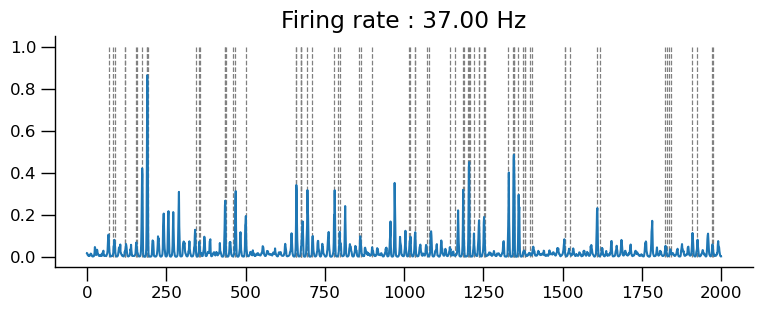

In [66]:
# del mu, alpha, F, omega, sigma, beta, y
log, x_true, x_prior, x_meas, P_prior, P_meas, y, [mu, alpha, F, omega, sigma, beta] = test_KF(N = 2000, K = 2000)

In [68]:
log.success.mean()

0.32416208104052024

In [69]:
log.msg.value_counts()

msg
Checking xm_k[0]    1351
Name: count, dtype: int64

In [70]:
log[log.success==False].mrd.astype(float).mean(), log[log.success==False].mad.astype(float).mean()

(5.886510028757218e-06, 1.7752076031276437e-07)

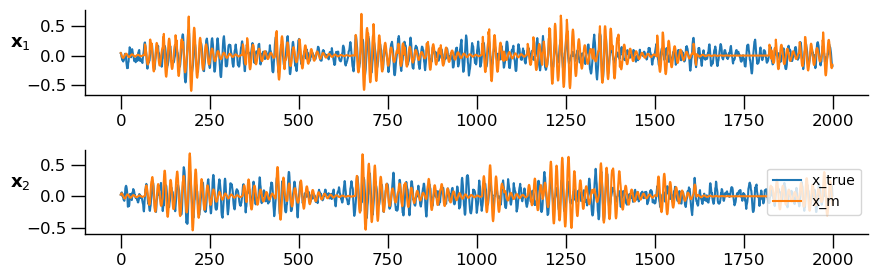

In [71]:
fig, axs = plt.subplots(2,1)

for ix, ax, xt, xm in zip(['$\\mathbf{x}_{1}$', '$\\mathbf{x}_{2}$'], axs, x_true, x_meas):
    # for yi in np.where(y)[0]:
    #     ax.axvline(yi, c='grey', ls='--')
    ax.plot(xt, label='x_true')
    ax.plot(xm, label='x_m')
    ax.set_ylabel(ix, rotation=0)
    # ax.stem(y, 'k--', markerfmt='')
    # ax.set_xlim([800, 1000])
ax.legend(fontsize=10, loc = 'right')
fig.tight_layout()
plt.show()

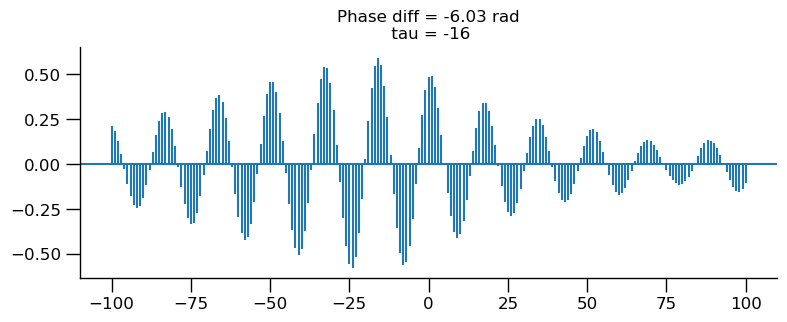

In [72]:
a = plt.xcorr(x_true[0], x_meas[0], normed=True, maxlags=100)
tau = a[0][np.argmax(a[1])]
plt.title(f'Phase diff = {2*np.pi*F*tau/1000 :.2f} rad\n tau = {tau}', fontsize=12)
plt.show()

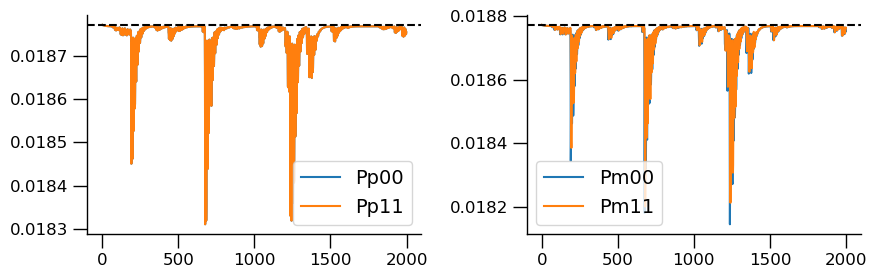

In [73]:
fig, (ax2, ax1) = plt.subplots(1,2)
ax1.plot(log.filter(regex='^H'))
ax1.legend(['Pm00', 'Pm11'])
ax1.axhline(P_meas[0,0,0], c='k', ls='--')
ax2.plot(P_prior[0, 0, 1:])
ax2.plot(P_prior[0, 0, 1:])
ax2.axhline(P_meas[0,0,0], c='k', ls='--')
ax2.legend(['Pp00', 'Pp11'])
fig.tight_layout()

In [74]:
for k in range(2000):
    if np.linalg.cond(P_prior[:, :, k]) <-10:
        print(k, 'prior-l', P_prior[:, :, k])
    if np.linalg.cond(P_meas[:, :, k]) < -10:
        print(k, 'meas-l', P_meas[:, :, k])

    if np.linalg.cond(P_prior[:, :, k]) >10:
        print(k, 'prior', P_prior[:, :, k])
    if np.linalg.cond(P_meas[:, :, k]) >10:
        print(k, 'meas', P_meas[:, :, k])

0 prior [[0. 0.]
 [0. 0.]]


In [75]:
np.var(x_meas)/np.var(x_true)

1.338575233337233

In [76]:
log.success.mean(), log.y.mean()

(0.32416208104052024, 0.03701850925462731)

In [77]:
log[log.mrd.astype(float) == log.mrd.astype(float).max()].filter(regex='^(xm|x1_check|x2_check|mrd|mad)').astype(float)

,xm0,xm1,x1_check,x2_check,mrd,mad
177,-0.000007,0.322405,-0.000007,0.322405,0.001066,7.984982e-09


In [79]:
x_smooth, P_smooth, AG = backward_pass(alpha, rot(omega), x_prior, x_meas, P_prior, P_meas, 2000)

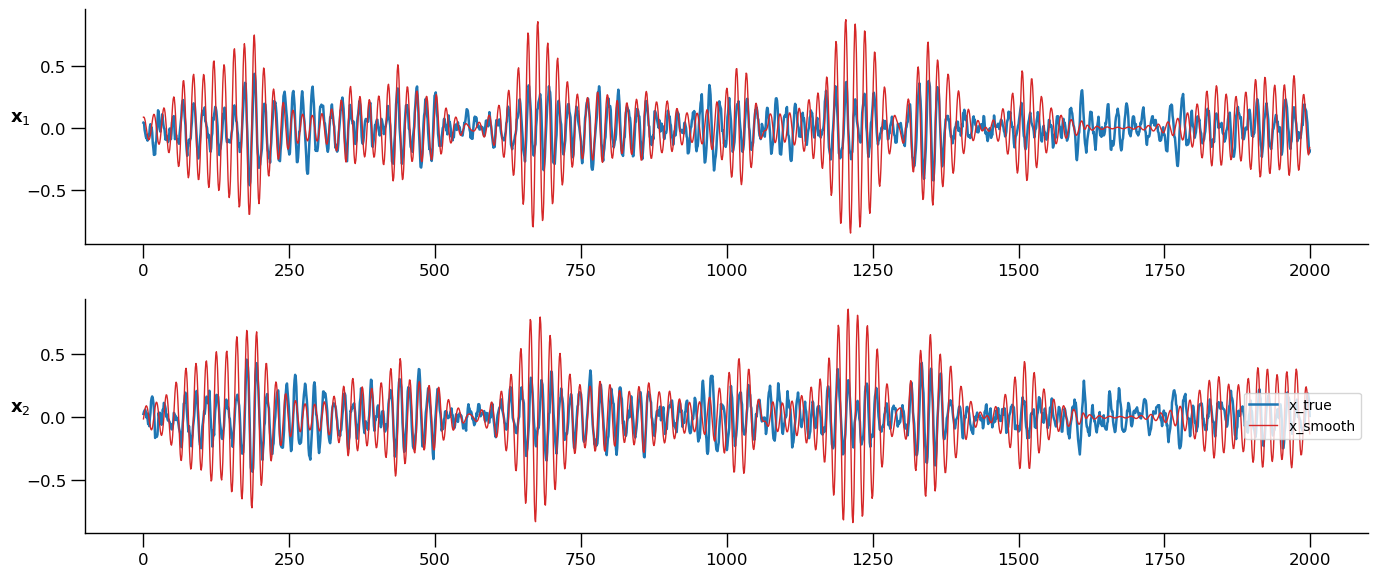

In [80]:
fig, axs = plt.subplots(2,1, figsize=(14, 6))

for ix, ax, xt, xm in zip(['$\\mathbf{x}_{1}$', '$\\mathbf{x}_{2}$'], axs, x_true, x_smooth):
    # for yi in np.where(y)[0]:
    #     ax.axvline(yi, c='grey', ls='--')
    ax.plot(xt, label='x_true', lw=1.8)
    ax.plot(xm, label='x_smooth', c='C3', lw=1)
    ax.set_ylabel(ix, rotation=0)
    # ax.stem(y, 'k--', markerfmt='')
    # ax.set_xlim([800, 1000])
ax.legend(fontsize=10, loc = 'right')
fig.tight_layout()
plt.show()

Estimated Phase Difference: 21.60 degrees


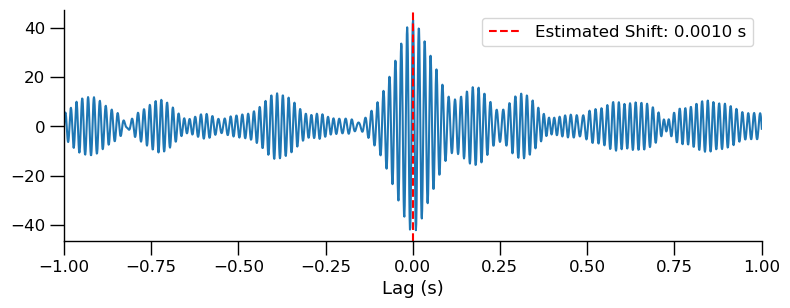

In [81]:
N = y.shape[0]
lags = np.arange(-N + 1, N)
xcorr = correlate(x_true[0], x_smooth[0], mode='full')
tau = lags[np.argmax(xcorr)] / 1000
estimated_phase_diff = 2 * np.pi * F * tau  # Convert to phase difference

print(f"Estimated Phase Difference: {np.rad2deg(estimated_phase_diff):.2f} degrees")

# Plot cross-correlation
plt.figure()
plt.plot(lags / 1000, xcorr)
plt.xlim([-1, 1])
plt.xlabel('Lag (s)')
plt.axvline(tau, color='r', linestyle='--', label=f'Estimated Shift: {tau:.4f} s')
plt.legend(fontsize=12)
plt.show()


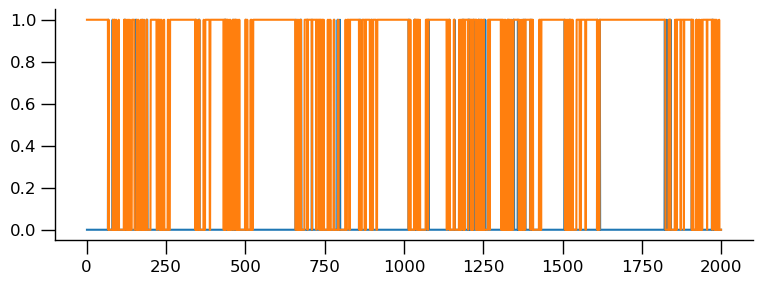

In [82]:
# plt.plot(log.xdiff.astype(float))
# plt.plot(log.mrd.astype(float)/1e3)
plt.plot(log.y)
plt.plot((1 - log.success))

### --> Fixed params, N = 20k

X dim : (2, 20000)
y dim : (20000,)
mu = -4.5000
alpha = 0.9730
F = 60.0000
omega = 0.3770
sigma^2 = 0.0010
beta = 8.0000


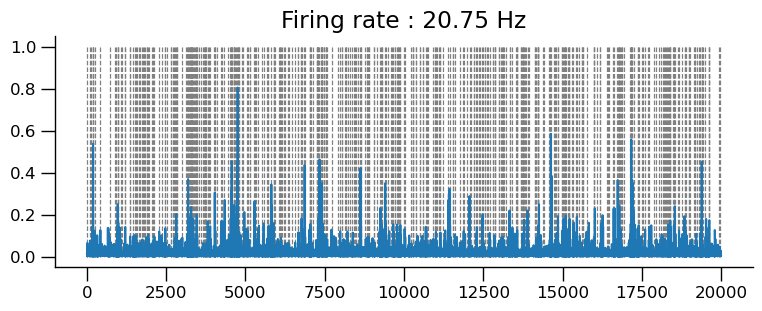

In [48]:
# del mu, alpha, F, omega, sigma, beta, y
log, x_true, x_prior, x_meas, P_prior, P_meas, y, [mu, alpha, F, omega, sigma, beta] = test_KF(N = 20000, K = 20000)

In [52]:
log.success.mean()

0.08350417520876044

In [53]:
log.msg.value_counts()

msg
Checking xm_k[0]    18329
Name: count, dtype: int64

In [54]:
log[log.success==False].mrd.astype(float).mean(), log[log.success==False].mad.astype(float).mean()

(6.82051288423531e-06, 1.9683113050332465e-07)

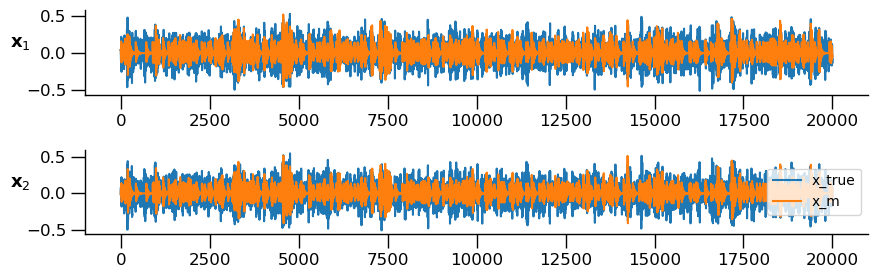

In [55]:
fig, axs = plt.subplots(2,1)

for ix, ax, xt, xm in zip(['$\\mathbf{x}_{1}$', '$\\mathbf{x}_{2}$'], axs, x_true, x_meas):
    # for yi in np.where(y)[0]:
    #     ax.axvline(yi, c='grey', ls='--')
    ax.plot(xt, label='x_true')
    ax.plot(xm, label='x_m')
    ax.set_ylabel(ix, rotation=0)
    # ax.stem(y, 'k--', markerfmt='')
    # ax.set_xlim([800, 1000])
ax.legend(fontsize=10, loc = 'right')
fig.tight_layout()
plt.show()

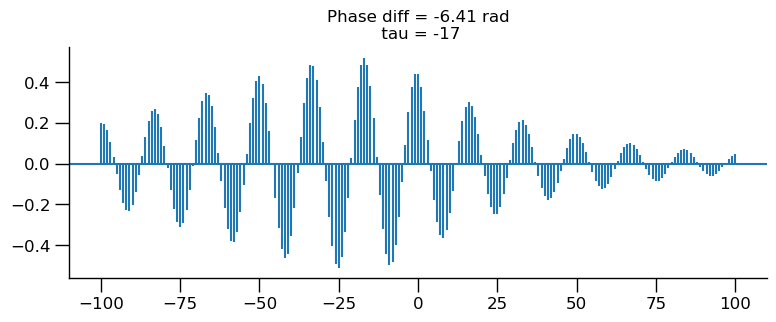

In [56]:
a = plt.xcorr(x_true[0], x_meas[0], normed=True, maxlags=100)
tau = a[0][np.argmax(a[1])]
plt.title(f'Phase diff = {2*np.pi*F*tau/1000 :.2f} rad\n tau = {tau}', fontsize=12)
plt.show()

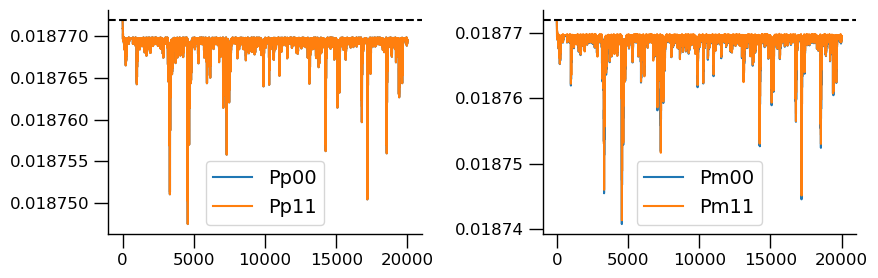

In [57]:
fig, (ax2, ax1) = plt.subplots(1,2)
ax1.plot(log.filter(regex='^H'))
ax1.legend(['Pm00', 'Pm11'])
ax1.axhline(P_meas[0,0,0], c='k', ls='--')
ax2.plot(P_prior[0, 0, 1:])
ax2.plot(P_prior[0, 0, 1:])
ax2.axhline(P_meas[0,0,0], c='k', ls='--')
ax2.legend(['Pp00', 'Pp11'])
fig.tight_layout()

In [59]:
for k in range(20000):
    if np.linalg.cond(P_prior[:, :, k]) <-10:
        print(k, 'prior-l', P_prior[:, :, k])
    if np.linalg.cond(P_meas[:, :, k]) < -10:
        print(k, 'meas-l', P_meas[:, :, k])

    if np.linalg.cond(P_prior[:, :, k]) >10:
        print(k, 'prior', P_prior[:, :, k])
    if np.linalg.cond(P_meas[:, :, k]) >10:
        print(k, 'meas', P_meas[:, :, k])

0 prior [[0. 0.]
 [0. 0.]]


In [60]:
np.var(x_meas)/np.var(x_true)

0.33923200962538136

In [61]:
log.success.mean(), log.y.mean()

(0.08350417520876044, 0.020751037551877592)

In [62]:
log[log.mrd.astype(float) == log.mrd.astype(float).max()].filter(regex='^(xm|x1_check|x2_check|mrd|mad)').astype(float)

,xm0,xm1,x1_check,x2_check,mrd,mad
792,-0.019261,2.644998e-07,-0.019261,2.581748e-07,0.024499,6.324932e-09


In [63]:
x_smooth, P_smooth, AG = backward_pass(alpha, rot(omega), x_prior, x_meas, P_prior, P_meas, 20000)

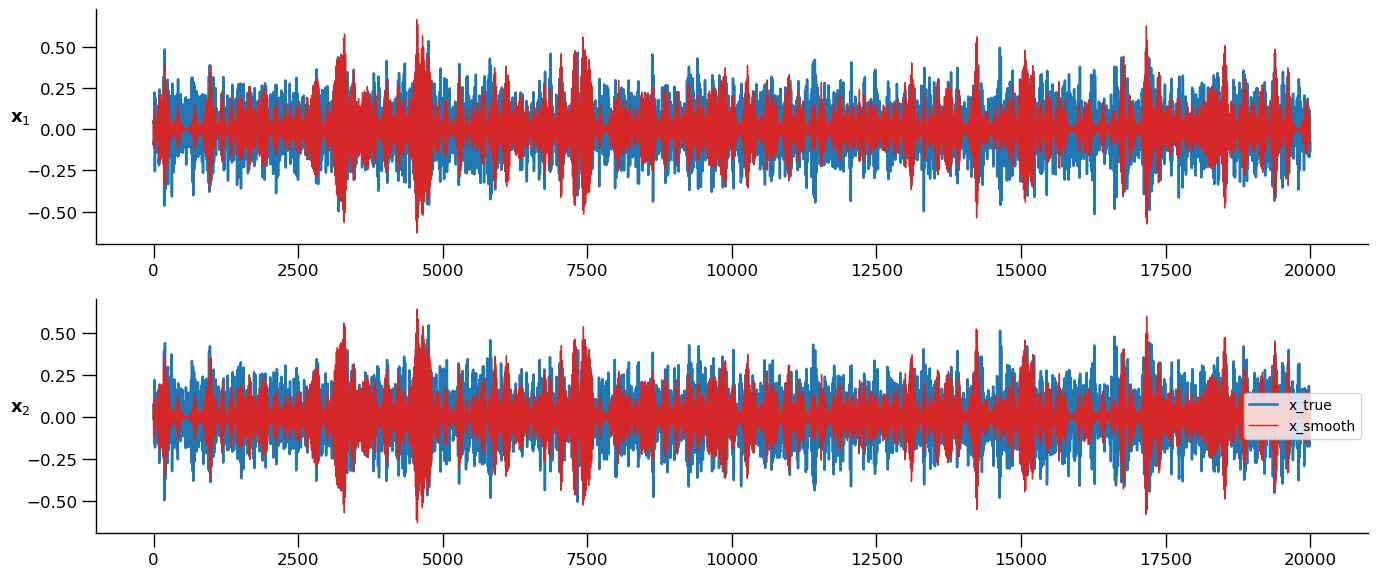

In [64]:
fig, axs = plt.subplots(2,1, figsize=(14, 6))

for ix, ax, xt, xm in zip(['$\\mathbf{x}_{1}$', '$\\mathbf{x}_{2}$'], axs, x_true, x_smooth):
    # for yi in np.where(y)[0]:
    #     ax.axvline(yi, c='grey', ls='--')
    ax.plot(xt, label='x_true', lw=1.8)
    ax.plot(xm, label='x_smooth', c='C3', lw=1)
    ax.set_ylabel(ix, rotation=0)
    # ax.stem(y, 'k--', markerfmt='')
    # ax.set_xlim([800, 1000])
ax.legend(fontsize=10, loc = 'right')
fig.tight_layout()
plt.show()

Estimated Phase Difference: 0.00 degrees


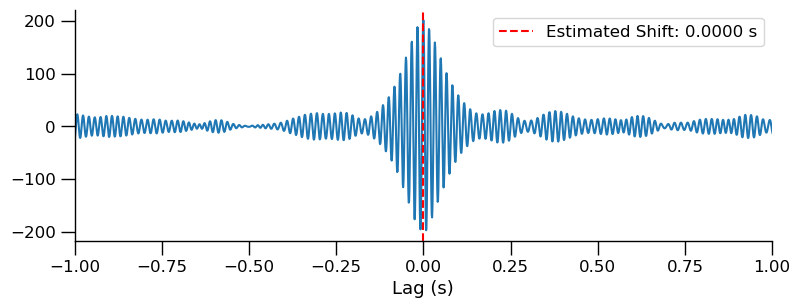

In [65]:
N = y.shape[0]
lags = np.arange(-N + 1, N)
xcorr = correlate(x_true[0], x_smooth[0], mode='full')
tau = lags[np.argmax(xcorr)] / 1000
estimated_phase_diff = 2 * np.pi * F * tau  # Convert to phase difference

print(f"Estimated Phase Difference: {np.rad2deg(estimated_phase_diff):.2f} degrees")

# Plot cross-correlation
plt.figure()
plt.plot(lags / 1000, xcorr)
plt.xlim([-1, 1])
plt.xlabel('Lag (s)')
plt.axvline(tau, color='r', linestyle='--', label=f'Estimated Shift: {tau:.4f} s')
plt.legend(fontsize=12)
plt.show()


## Test jac and hess

- Compared hessian when estimated by '2-point' method
- Checked that L and jacobian were calculated properly
- Check that jacobian(result.x) and hessian(result.x) match
- Also checked fprime(jacobian) = result.hessian
- All of the above match well using assert_allclose()
- Hand calculations are checked in test_KF()

In [5]:
def likelihood(x, xm, Pinv, dN, mu_c, Ts, beta):
    dot2 = (-1/2)*np.linalg.multi_dot([(x - xm).T, Pinv, x - xm])
    L = dN*(mu_c + beta*x[0] + np.log(Ts)) - np.exp(mu_c + beta*x[0])*Ts + dot2
    return -L

def jacobian(x, xm, Pinv, dN, mu_c, Ts, beta):
    jac = -np.dot(Pinv, x - xm)
    jac[0] += (dN - np.exp(mu_c + beta*x[0])*Ts)*beta
    return  -jac

def hessian(x, xm, Pinv, dN, mu_c, Ts, beta):
    hess = -Pinv.copy()
    hess[0,0] -= np.exp(mu_c + beta*x[0])*Ts*np.power(beta, 2)
    return -hess

def rot(w): 
    return np.array([[np.cos(w), -np.sin(w)], [np.sin(w), np.cos(w)]], dtype=np.float64)

In [6]:
def max_L(xp_k, Pinv_k, y, mu_c, Delta, beta, method='trust-krylov'):
    return minimize(likelihood, xp_k, args=(xp_k, Pinv_k, y, mu_c, Delta, beta), 
                           jac=jacobian, hess=hessian, method = method)
    

In [148]:
def test_jac(n_runs = 100):

    log = pd.DataFrame(columns = ['run', 'success', 'y', 'mu', 'alpha', 'beta', 'x0', 'x1', 'xm0', 'xm1', 
                                  'P00', 'P11', 'H00', 'H11', 'HInv00', 'HInv11', 'msg', 'tol_msg', 'mrd', 'mad'])
    for n_run in range(n_runs):
        try:
            rng = np.random.default_rng()
            x = rng.random(2)
            mu = 2*rng.random() - 5
            beta = rng.random()*8
            # beta = 1
            Delta = 1e-3
            alpha = 0.238*rng.random() + 0.75
            
            # P = gen_test_P()
            P = (0.001/(1 - np.power(alpha, 2)))*np.eye(2)

            # P_try = 
            Pinv = np.linalg.pinv(P)
            obs = np.exp(mu + beta*x[0])
            if obs > rng.random():
                y = 1
            else:
                y = 0
                
            res = minimize(likelihood, x, args=(x, Pinv, y, mu, Delta, beta), 
                           jac=jacobian, hess=hessian, method = 'trust-krylov')
            
            est = minimize(likelihood, x, args=(x, Pinv, y, mu, Delta, beta), 
                           jac=jacobian, hess='2-point', method = 'trust-krylov')
            
            np.testing.assert_allclose(res.fun, est.fun,  err_msg = 'Comparing L outputs, res.fun, est.fun')
            np.testing.assert_allclose(hessian(res.x, x, Pinv, y, mu, Delta, beta), res.hess,  
                                       err_msg = 'Comparing res.hess with function')
            np.testing.assert_allclose(jacobian(res.x, x, Pinv, y, mu, Delta, beta), res.jac,  
                                       err_msg = 'Comparing res.jac with function')
            np.testing.assert_allclose(approx_fprime(est.x, jacobian, 1e-6, x, Pinv, y, mu, Delta, beta), res.hess,
                                       err_msg = 'Comparing res.hess with fprime(jacobian)')

            hess_inv = np.linalg.pinv(res.hess)
            
            log.loc[n_run, :] = [n_run, True, y, mu, alpha, beta, x[0], x[1], res.x[0], res.x[1], 
                                 P[0,0], P[1,1], res.hess[0,0], res.hess[1,1], hess_inv[0,0], hess_inv[1,1], *[np.nan]*4]
        except AssertionError as e:
            log.loc[n_run, :] = [n_run, False, y, mu, alpha, beta, x[0], x[1], res.x[0], res.x[1], 
                                 P[0,0], P[1,1], res.hess[0,0], res.hess[1,1], hess_inv[0,0], hess_inv[1,1], *split_err(e)]
    
    return log
    


In [149]:
log = test_jac(2000)

In [150]:
log[log.success==False]

,run,success,y,mu,alpha,beta,x0,x1,xm0,xm1,P00,P11,H00,H11,HInv00,HInv11,msg,tol_msg,mrd,mad
135,135,False,1,-3.016696,0.97543,7.981479,0.789068,0.024699,0.939029,0.024699,0.020603,0.020603,54.146488,48.53599,0.003738,0.003738,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",4.13475862e-07,2.23882658e-05
480,480,False,1,-3.763916,0.962096,7.63097,0.869503,0.402044,0.968259,0.402044,0.013446,0.013446,76.556269,74.371485,0.01641,0.016412,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",1.08881052e-07,8.33552713e-06
494,494,False,1,-4.6132,0.983755,7.471795,0.886664,0.197929,1.109362,0.197929,0.03103,0.03103,34.430607,32.22668,0.003758,0.003758,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",2.39100803e-07,8.23238582e-06
600,600,False,1,-3.459169,0.982075,7.169553,0.987812,0.275801,1.163057,0.275801,0.028146,0.028146,42.291849,35.529574,0.006004,0.006004,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",5.73230197e-07,2.42429652e-05
672,672,False,1,-4.067862,0.978102,7.092558,0.873504,0.763921,1.03298,0.763921,0.023085,0.023085,44.625986,43.317406,0.002343,0.002343,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",1.03965982e-07,4.63958446e-06
816,816,False,1,-3.251083,0.974371,6.845465,0.864666,0.262739,0.995186,0.262739,0.019762,0.019762,52.251101,50.600987,0.00613,0.00613,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",1.08090863e-07,5.64786654e-06
965,965,False,1,-4.211243,0.987941,7.868136,0.945153,0.890447,1.20803,0.890447,0.041715,0.041715,36.296709,23.972195,0.004721,0.004721,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",1.33582429e-06,4.84860258e-05
1049,1049,False,1,-3.80118,0.930086,7.75887,0.987953,0.019041,1.041305,0.019041,0.007411,0.007411,139.281204,134.940271,0.005989,0.005989,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",1.20909618e-07,1.68404372e-05
1216,1216,False,1,-4.128048,0.955347,7.787371,0.984135,0.526942,1.067467,0.526942,0.011453,0.011453,91.295614,87.312904,0.003542,0.003543,Comparing res.hess with fprime(jacobian),"Not equal to tolerance rtol=1e-07, atol=0",1.69858855e-07,1.55073684e-05


In [ ]:
def test_param(N=1000):
    '''
    Make beta match whatever random mu is used
    '''
    rng = np.random.default_rng()

    #Input constants
    mu = 2*rng.random() - 5 #20*rng.random() - 10
    beta = 8 # beta = rng.random()*8
    sigma = 0.001
    Delta = 1e-3
    alpha = 0.248*rng.random() + 0.75
    F = 100*rng.random() + 20
    omega = 2*np.pi*F/1000
    R = rot(omega)
    
    # Inputs 
    u = rng.normal(0, scale=np.sqrt(sigma), size=(2,N))
    X = np.zeros_like(u)
    
    X[:, 0] = u[:, 0]
    for k in range(1,N):
        X[:, k] = alpha*np.dot(R, X[:, k-1]) + u[:, k]

    obs = np.exp(mu + beta*X[0])

    while obs.max() < 0.75:
        if beta > 20:
            break
        beta += 1
        obs = np.exp(mu + beta*X[0])

    while obs.max() >= 1.2:
        if beta < 2:
            break
        beta -= 1
        obs = np.exp(mu + beta*X[0])
    
    y = np.zeros_like(obs)
    for i, yi in enumerate(obs):
        if yi > rng.random():
            y[i] = 1

    
    print(f'X dim : {X.shape}')
    print(f'y dim : {y.shape}')
    for var, name in zip([mu, alpha, F, omega, sigma, beta], ['mu', 'alpha', 'F', 'omega', 'sigma^2', 'beta']):
        print(f'{name} = {var:.4f}')

    fig, ax = plt.subplots()
    for i in np.where(y)[0]:
        ax.plot(y, '--', color='grey', lw=0.5)
    ax.plot(obs)

    print(f'Firing rate : {y.mean()/Delta : .2f} Hz')

# Full KF Filter function

In [3]:
def rot(w): 
    return np.array([[np.cos(w), -np.sin(w)], [np.sin(w), np.cos(w)]], dtype=np.float64)

In [4]:
def likelihood(x, xm, Pinv, dN, mu_c, Ts, beta):
    dot2 = (-1/2)*np.linalg.multi_dot([(x - xm).T, Pinv, x - xm])
    L = dN*(mu_c + beta*x[0] + np.log(Ts)) - np.exp(mu_c + beta*x[0])*Ts + dot2
    return -L

def jacobian(x, xm, Pinv, dN, mu_c, Ts, beta):
    jac = -np.dot(Pinv, x - xm)
    jac[0] += (dN - np.exp(mu_c + beta*x[0])*Ts)*beta
    return  -jac

def hessian(x, xm, Pinv, dN, mu_c, Ts, beta):
    hess = -Pinv.copy()
    hess[0,0] -= np.exp(mu_c + beta*x[0])*Ts*np.power(beta, 2)
    return -hess

In [5]:
def max_L(x0, xp_k, Pinv_k, y, mu_c, Delta, beta, method='trust-krylov'):
    return minimize(likelihood, x0, args=(xp_k, Pinv_k, y, mu_c, Delta, beta), 
                           jac=jacobian, hess=hessian, method = method)

In [65]:
def KF_step(x_m_k1, P_m_k1, alpha, sigma, R, mu, Delta, beta, y_k, method='trust-krylov'):
    #Prediction Step
    xp_k = alpha * np.dot(R, x_m_k1)
    Pp_k = np.power(alpha, 2) * np.linalg.multi_dot([R, P_m_k1, R.T]) + sigma*np.eye(2)
    
    Pinv_k = np.linalg.pinv(Pp_k)

    # Measurement step : maximizing likelihood function
    # Using x_{k|k-1} as initial estimate for minimize function
    res = max_L(x_m_k1, xp_k, Pinv_k, y_k, mu, Delta, beta, method=method)
    
    if not res.success:
        print("Estimation of $x_{m, k}$  failed to converge : " + res.message)
        raise AssertionError("Estimation of $x_{m, k}$  failed to converge : " + res.message)

    Pm_k = np.linalg.pinv(res.hess) # Negative not required because hessian function minimizes the "negative likelihood".
    return xp_k, res.x, Pp_k, Pm_k
    

In [7]:
def backward_pass(alpha, R, x_p, x_m, P_p, P_m, K):
    AG = np.zeros((2,2,K))
    x_b = np.zeros((2,K))
    P_b = np.zeros((2,2,K))
    x_b[:, -1] = x_m[:, -1].copy()
    P_b[:, :, -1] = P_m[:, :, -1].copy()
    for k in range(K-1, 0, -1):
        A_k1 = np.linalg.multi_dot([P_m[:, :, k-1], alpha*R.T, np.linalg.pinv(P_p[:, :, k])])
        AG[:, :, k-1] = A_k1

        x_b[:, k-1] = x_m[:, k-1] + np.dot(A_k1, x_b[:, k] - x_p[:, k])
        P_b[:, :, k-1] = P_m[:, :, k-1] + np.linalg.multi_dot([A_k1, P_b[:, :, k] - P_p[:, :, k], A_k1.T])
        
    return x_b, P_b, AG

In [66]:
def KFilter(x0, y, mu, beta, sigma, alpha, F, Delta, K=None):

    if not K:
        K = y.shape[1]
    
    omega = 2*np.pi*F/1000
    R = rot(omega)
    
    x_p = np.zeros((2,K))
    x_m = np.zeros((2,K))
    
    P_p = np.zeros((2,2,K))
    P_m = np.zeros((2,2,K))

    P_m[:, :, 0] = (sigma/(1 - np.power(alpha, 2)))*np.eye(2) #steady state calculation of P_m as an estimate of P_0|0
    x_m[:, 0] = x0.copy()

    #Forward Pass : Kalman Filter
    for k in range(1, K):
        xp_k, xm_k, Pp_k, Pm_k = KF_step(x_m[:, k-1], P_m[:, :, k-1], 
                                                 alpha, sigma, R, mu, Delta, beta, y[k], method='trust-krylov')
        x_p[:, k], P_p[:, :, k], x_m[:, k], P_m[:, :, k] = xp_k, Pp_k, xm_k, Pm_k

    #Backward Pass
    x_b, P_b, AG = backward_pass(alpha, R, x_p, x_m, P_p, P_m, K)
    
    return x_p, x_m, x_b, P_p, P_m, P_b, AG
        

In [11]:
def get_params(N = 1000, random = True, plot = False, print_params = False):

    # Randomly choose input constants that fit expected criteria for observation signal
    if random:
        rng = np.random.default_rng()
        mu = 2*rng.random() - 5  # range (-5, -3)
        beta = 8 # beta is modified below to ensure that y spikes approx comes from peaks of obs; beta range (1, 21)
        alpha = 0.248*rng.random() + 0.75 # range (0.75, 0.999)
        F = 100*rng.random() + 20 # range (20, 120)

        # Keeping these fixed for now
        sigma = 0.001 
        Fs = 1000
        Delta = 1/Fs
        
        omega = 2*np.pi*F/Fs
        R = rot(omega)
    
        # Inputs 
        u = rng.normal(0, scale=np.sqrt(sigma), size=(2,N))
        X = np.zeros_like(u)
        X[:, 0] = u[:, 0]
        for k in range(1,N):
            X[:, k] = alpha*np.dot(R, X[:, k-1]) + u[:, k]
        obs = np.exp(mu + beta*X[0])

        # Ensuring obs is in the *right* range of ~ (0, 1) so np.exp(mu + beta*x[0]) isn't too large
        while obs.max() < 0.75:
            if beta > 20:
                break
            beta += 1
            obs = np.exp(mu + beta*X[0])
    
        while obs.max() >= 1.05:
            if beta < 2:
                break
            beta -= 1
            obs = np.exp(mu + beta*X[0])
        
        # y spikes whenever obs > random_number
        y = np.zeros_like(obs)
        for i, yi in enumerate(obs):
            if yi > rng.random():
                y[i] = 1
    
    #fixed parameter values
    else:
        rng = np.random.default_rng(42)
        mu = -4.5
        beta = 10
        sigma = 0.001
        alpha = 0.973
        F = 60
        Fs = 1000
        Delta = 1/Fs
        omega = 2*np.pi*F/Fs
        R = rot(omega)

        u = rng.normal(0, scale=np.sqrt(sigma), size=(2,N))
        X = np.zeros_like(u)
        X[:, 0] = u[:, 0]
        for k in range(1,N):
            X[:, k] = alpha*np.dot(R, X[:, k-1]) + u[:, k]
        obs = np.exp(mu + beta*X[0])
        y = np.zeros_like(obs)
        for i, yi in enumerate(obs):
            if yi > rng.random():
                y[i] = 1
        
    if plot:
        fig, ax = plt.subplots()
        ax.vlines(np.where(y)[0], ymin=0, ymax = 1, ls='--', color='grey', lw=0.85)
        ax.plot(obs)
        ax.set_xlabel('Samples', fontsize=12)
        ax.set_ylabel('$e^{\\mu + \\beta x_{1}}$')
        ax.set_title(f'Firing rate : {y.mean()*Fs} Hz', fontsize=12)

    if print_params:
        print(f'X dims : {X.shape}')
        print(f'y dims : {y.shape}')
        for name, var in zip(['N', 'Fs', 'Delta', 'alpha', 'F', 'omega', 'sigma', 'mu', 'beta', 'R'], 
                             [N, Fs, Delta, alpha, F, omega, sigma, mu, beta, R]):
            print(f'{name} : {np.round(var, 4)}')

    return X, y, N, Fs, Delta, alpha, F, omega, R, sigma, mu, beta


## -> Fixed param run

X dims : (2, 2000)
y dims : (2000,)
N : 2000
Fs : 1000
Delta : 0.001
alpha : 0.973
F : 60
omega : 0.377
sigma : 0.001
mu : -4.5
beta : 10
R : [[ 0.9298 -0.3681]
 [ 0.3681  0.9298]]


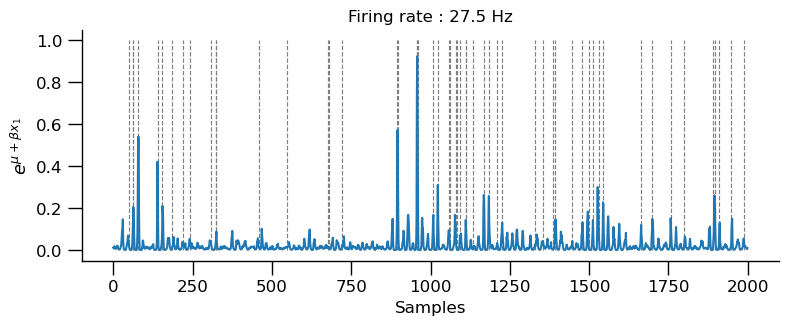

In [331]:
X, y, N, Fs, Delta, alpha, F, omega, R, sigma, mu, beta = get_params(N=2000, random = False, print_params=True, plot=True)

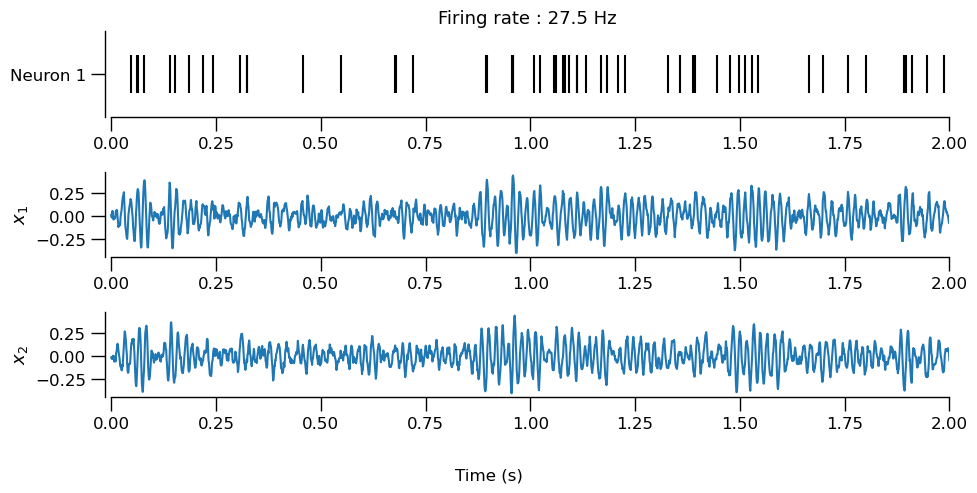

In [286]:
fig, (ax, ax2, ax3) = plt.subplots(3,1, figsize=(10, 5))

time = np.linspace(0, N/Fs, N)
ax.eventplot(np.where(y)[0]/Fs, colors='k', lineoffsets=1, linelengths=1)
# ax.set_xticks(np.linspace(0,N,9), np.linspace(0,N/Fs,9))
# ax.plot(np.where(y)[0], [1]*np.sum(y).astype(int), 'r*')
ax.set_xlim([-15/Fs, N/Fs])
ax.spines['bottom'].set_bounds(0, N/Fs)
ax.set_yticks([1], ['Neuron 1'])
ax.set_title(f'Firing rate : {np.mean(y)*Fs} Hz', fontsize=13)

ax2.plot(time, X[0])
ax2.set_ylabel('$x_{1}$', rotation='vertical')
ax2.set_xlim([-15/Fs, N/Fs])
ax2.spines['bottom'].set_bounds(0, N/Fs)

ax3.plot(time, X[1])
ax3.set_xlim([-15/Fs, N/Fs])
ax3.spines['bottom'].set_bounds(0, N/Fs)
ax3.set_ylabel('$x_{2}$', rotation='vertical')
fig.supxlabel('Time (s)', fontsize=12)
fig.tight_layout()
plt.show()

In [287]:
x_pred, x_meas, x_smooth, P_pred, P_meas, P_smooth, AG = KFilter(X[:, 0], y, mu, beta, sigma, alpha, F, Delta, K=N)

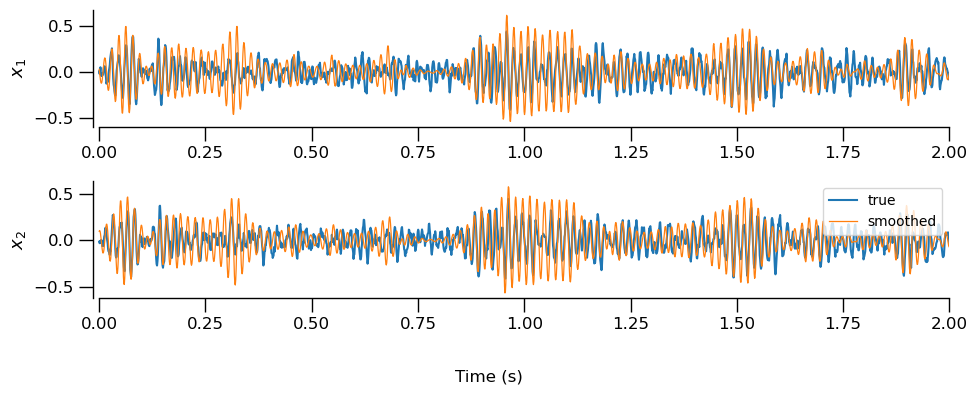

In [288]:
fig, axs = plt.subplots(2,1, figsize=(10, 4))

time = np.linspace(0, N/Fs, N)

for ax, xt, xs, name in zip(axs, X, x_smooth, ['$x_{1}$', '$x_{2}$']):
    ax.plot(time, xt, label = 'true')
    ax.plot(time, xs, label = 'smoothed', lw = 0.9)
    ax.set_ylabel(name, rotation='vertical')
    ax.set_xlim([-15/Fs, N/Fs])
    ax.spines['bottom'].set_bounds(0, N/Fs)

ax.legend(fontsize=10)
fig.supxlabel('Time (s)', fontsize=12)
fig.tight_layout()
plt.show()

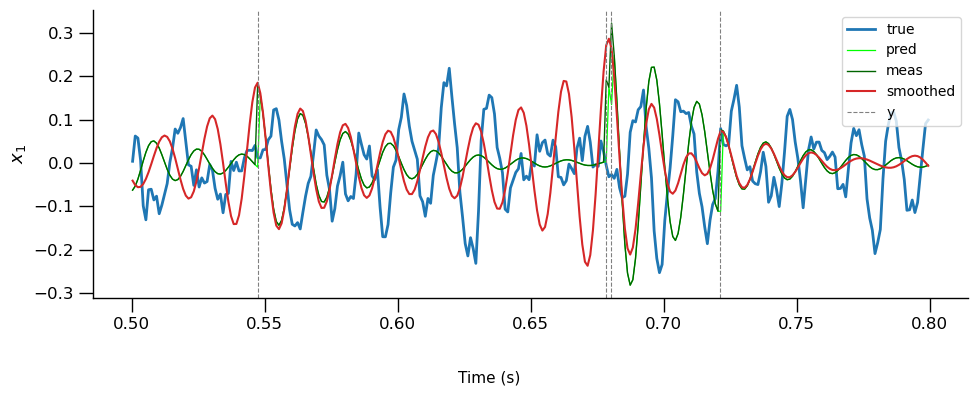

In [289]:
fig, ax = plt.subplots(figsize=(10, 4))

time = np.linspace(0, N/Fs, N)
idx = np.arange(500, 800)
for xx, name, lw, col in zip([X, x_pred, x_meas, x_smooth], ['true', 'pred', 'meas', 'smoothed'], 
                    [2, 0.9, 1, 1.5], ['C0', 'lime', 'darkgreen', 'C3']):
    ax.plot(time[idx], xx[0][idx], label = name, lw=lw, c=col)
for yi in np.where(y[idx])[0]/Fs:
    ax.axvline(yi + time[idx[0]], ls = '--', color='grey', lw=0.8)
ax.set_ylabel('$x_1$', rotation='vertical')

ax.legend(['true', 'pred', 'meas', 'smoothed', 'y'], fontsize=10, loc = 'upper right')
fig.supxlabel('Time (s)', fontsize=11)
fig.tight_layout()
plt.show()

Estimated Phase Difference: 0.00 degrees


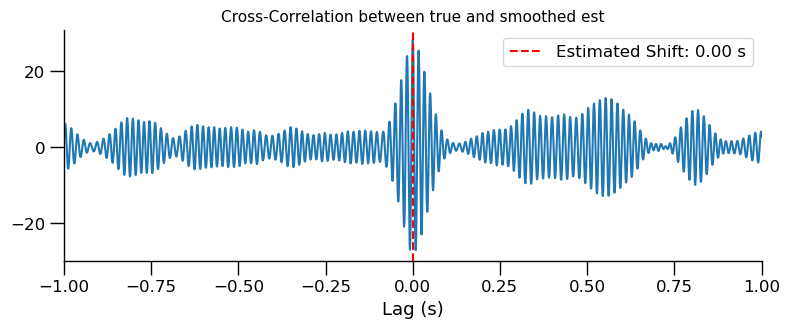

In [290]:
lags = np.arange(-N + 1, N)
xcorr = correlate(X[0], x_smooth[0], mode='full')
tau = lags[np.argmax(xcorr)] / Fs
estimated_phase_diff = 2 * np.pi * F * tau  # Convert to phase difference

print(f"Estimated Phase Difference: {np.rad2deg(estimated_phase_diff):.2f} degrees")

# Plot cross-correlation
plt.figure()
plt.plot(lags / Fs, xcorr)
plt.xlim([-1, 1])
plt.xlabel('Lag (s)')
# plt.ylabel('Cross-correlation', fontsize=10)
plt.title('Cross-Correlation between true and smoothed est', fontsize=11)
plt.axvline(tau, color='r', linestyle='--', label=f'Estimated Shift: {tau:.2f} s')
plt.legend(fontsize=12)
plt.show()


In [291]:
y1_h = hilbert(X[0])
y2_h = hilbert(x_smooth[0])
phase1 = np.angle(y1_h)
phase2 = np.angle(y2_h)
pd1 = np.unwrap(phase1 - phase2).mean()
print(f'Mean Inst. Phase diff for x[1] : {pd1:.2f} rad / {np.rad2deg(pd1):.0f} degrees')

Mean Inst. Phase diff for x[1] : 27.81 rad / 1593 degrees


In [292]:
y1_h = hilbert(X[1])
y2_h = hilbert(x_smooth[1])
phase1 = np.angle(y1_h)
phase2 = np.angle(y2_h)
pd2 = np.unwrap(phase1 - phase2).mean()
print(f'Mean Inst. Phase diff for x[1] : {pd2:.2f} rad / {np.rad2deg(pd2):.0f} degrees')

Mean Inst. Phase diff for x[1] : 18.20 rad / 1043 degrees


## -> Random param run

X dims : (2, 2000)
y dims : (2000,)
N : 2000
Fs : 1000
Delta : 0.001
alpha : 0.8987
F : 106.6284
omega : 0.67
sigma : 0.001
mu : -3.4357
beta : 14
R : [[ 0.7838 -0.621 ]
 [ 0.621   0.7838]]


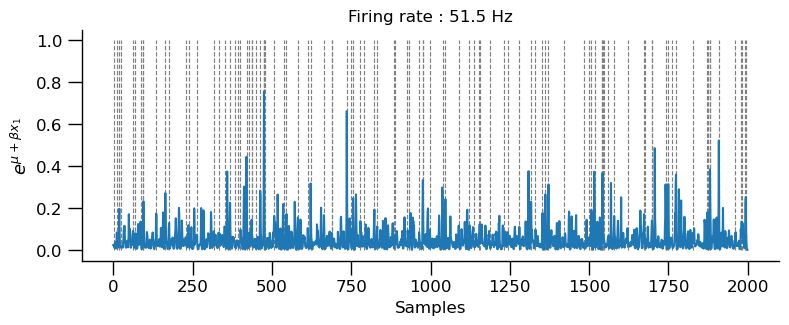

In [12]:
X, y, N, Fs, Delta, alpha, F, omega, R, sigma, mu, beta = get_params(N=2000, random = True, print_params=True, plot=True)

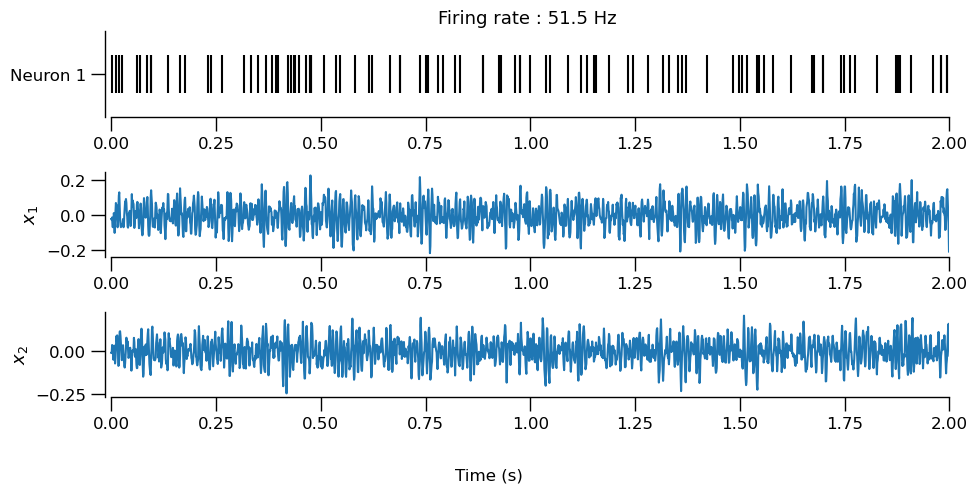

In [13]:
fig, (ax, ax2, ax3) = plt.subplots(3,1, figsize=(10, 5))

time = np.linspace(0, N/Fs, N)
ax.eventplot(np.where(y)[0]/Fs, colors='k', lineoffsets=1, linelengths=1)
# ax.set_xticks(np.linspace(0,N,9), np.linspace(0,N/Fs,9))
# ax.plot(np.where(y)[0], [1]*np.sum(y).astype(int), 'r*')
ax.set_xlim([-15/Fs, N/Fs])
ax.spines['bottom'].set_bounds(0, N/Fs)
ax.set_yticks([1], ['Neuron 1'])
ax.set_title(f'Firing rate : {np.mean(y)*Fs} Hz', fontsize=13)

ax2.plot(time, X[0])
ax2.set_ylabel('$x_{1}$', rotation='vertical')
ax2.set_xlim([-15/Fs, N/Fs])
ax2.spines['bottom'].set_bounds(0, N/Fs)

ax3.plot(time, X[1])
ax3.set_xlim([-15/Fs, N/Fs])
ax3.spines['bottom'].set_bounds(0, N/Fs)
ax3.set_ylabel('$x_{2}$', rotation='vertical')
fig.supxlabel('Time (s)', fontsize=12)
fig.tight_layout()
plt.show()

In [14]:
x_pred, x_meas, x_smooth, P_pred, P_meas, P_smooth, AG = KFilter(X[:, 0], y, mu, beta, sigma, alpha, F, Delta, K=N)

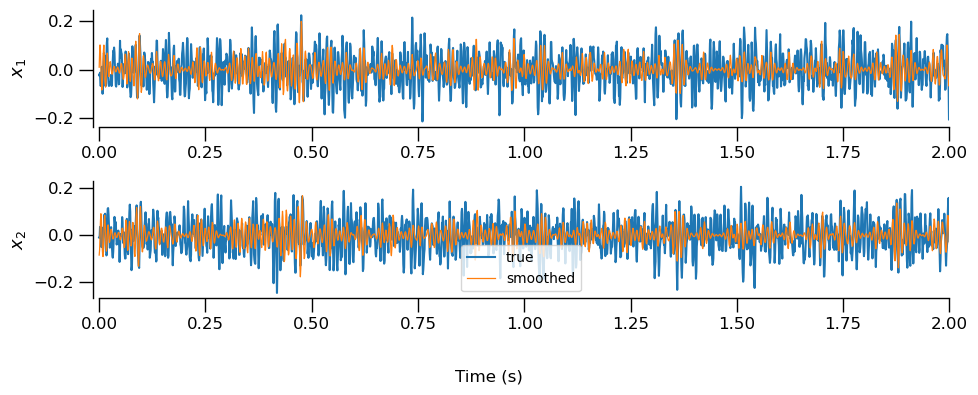

In [15]:
fig, axs = plt.subplots(2,1, figsize=(10, 4))

time = np.linspace(0, N/Fs, N)

for ax, xt, xs, name in zip(axs, X, x_smooth, ['$x_{1}$', '$x_{2}$']):
    ax.plot(time, xt, label = 'true')
    ax.plot(time, xs, label = 'smoothed', lw = 0.9)
    ax.set_ylabel(name, rotation='vertical')
    ax.set_xlim([-15/Fs, N/Fs])
    ax.spines['bottom'].set_bounds(0, N/Fs)

ax.legend(fontsize=10)
fig.supxlabel('Time (s)', fontsize=12)
fig.tight_layout()
plt.show()

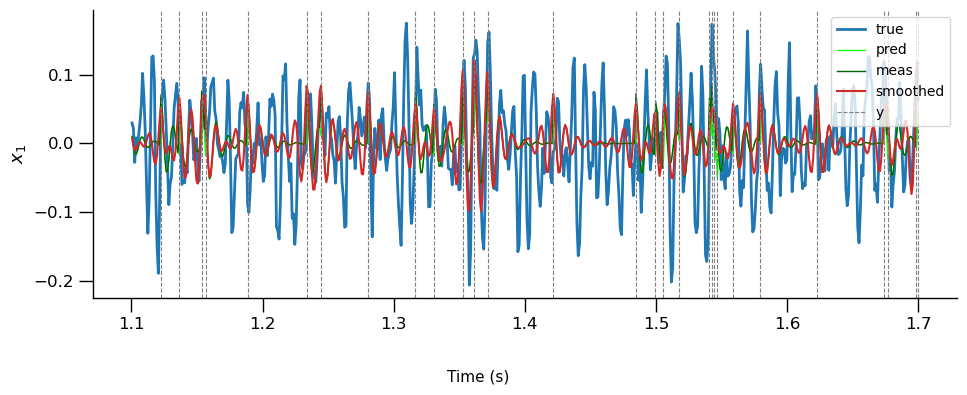

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))

time = np.linspace(0, N/Fs, N)
idx = np.arange(1100, 1700)
for xx, name, lw, col in zip([X, x_pred, x_meas, x_smooth], ['true', 'pred', 'meas', 'smoothed'], 
                    [2, 0.9, 1, 1.5], ['C0', 'lime', 'darkgreen', 'C3']):
    ax.plot(time[idx], xx[0][idx], label = name, lw=lw, c=col)
for yi in np.where(y[idx])[0]/Fs:
    ax.axvline(yi + time[idx[0]], ls = '--', color='grey', lw=0.8)
ax.set_ylabel('$x_1$', rotation='vertical')

ax.legend(['true', 'pred', 'meas', 'smoothed', 'y'], fontsize=10, loc = 'upper right')
fig.supxlabel('Time (s)', fontsize=11)
fig.tight_layout()
plt.show()

Estimated Phase Difference: 0.00 degrees


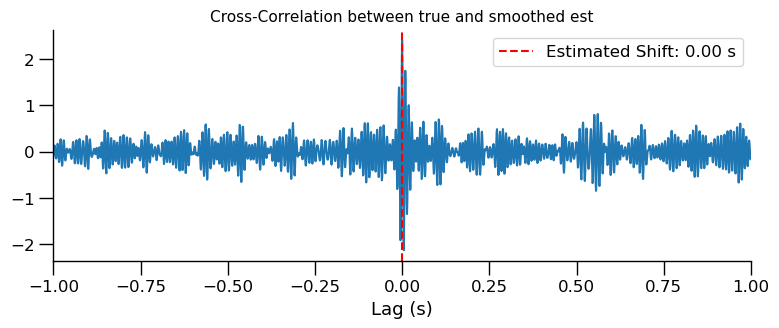

In [17]:
lags = np.arange(-N + 1, N)
xcorr = correlate(X[0], x_smooth[0], mode='full')
tau = lags[np.argmax(xcorr)] / Fs
estimated_phase_diff = 2 * np.pi * F * tau  # Convert to phase difference

print(f"Estimated Phase Difference: {np.rad2deg(estimated_phase_diff):.2f} degrees")

# Plot cross-correlation
plt.figure()
plt.plot(lags / Fs, xcorr)
plt.xlim([-1, 1])
plt.xlabel('Lag (s)')
# plt.ylabel('Cross-correlation', fontsize=10)
plt.title('Cross-Correlation between true and smoothed est', fontsize=11)
plt.axvline(tau, color='r', linestyle='--', label=f'Estimated Shift: {tau:.2f} s')
plt.legend(fontsize=12)
plt.show()


In [18]:
y1_h = hilbert(X[0])
y2_h = hilbert(x_smooth[0])
phase1 = np.angle(y1_h)
phase2 = np.angle(y2_h)
pd = np.unwrap(phase1 - phase2).mean()
print(f'Mean Inst. Phase diff for x[1] : {pd:.2f} rad / {np.rad2deg(pd):.0f} degrees')

Mean Inst. Phase diff for x[1] : 24.49 rad / 1403 degrees


In [19]:
y1_h = hilbert(X[1])
y2_h = hilbert(x_smooth[1])
phase1 = np.angle(y1_h)
phase2 = np.angle(y2_h)
pd = np.unwrap(phase1 - phase2).mean()
print(f'Mean Inst. Phase diff for x[1] : {pd:.2f} rad / {np.rad2deg(pd):.0f} degrees')

Mean Inst. Phase diff for x[1] : 21.34 rad / 1223 degrees


In [20]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

np.rad2deg(wrap_to_pi(pd))




142.87165529317718

# EM Steps

In [67]:
def E_step(x_b, P_b, AG, K):
    A = np.zeros((2,2))
    for k in range(1, K):
        A += P_b[:, :, k-1] + np.dot(x_b[:, k-1], x_b[:, k-1].T)
        
    B = np.zeros((2,2))
    for k in range(1, K):
        B += np.dot(P_b[:, :, k], AG[:, :, k-1].T) + np.dot(x_b[:, k], x_b[:, k-1].T)
        
    C = np.zeros((2,2))
    for k in range(1, K):
        C += P_b[:, :, k] + np.dot(x_b[:, k], x_b[:, k].T)
        
    return A, B, C

In [110]:
def M_step(A, B, C, x_b, P_b, dN, K, beta, Delta):

    omega_h = np.arctan2(B[1,0] - B[0,1], np.trace(B))
    alpha_h = (np.trace(B)*np.cos(omega_h) + (B[1,0] - B[0,1])*np.sin(omega_h)) / np.trace(A)
    sigma_h = (np.trace(C) - np.power(alpha_h, 2)*np.trace(A))/(2*K)
    
    exp_sum = np.exp(beta*x_b[0, :] + np.power(beta,2)*P_b[0,0, : ]/2).sum()
    mu_h = np.log(np.sum(dN)) - np.log(exp_sum) - np.log(Delta)

    return mu_h, alpha_h, omega_h, sigma_h

In [111]:
def run_EM(y, x0, mu0, beta, sigma0, alpha0, F0, Delta, iters = 100, method='trust-krylov'):

    K = len(y)

    
    omega0 = 2*np.pi*F0*Delta
    
    params = pd.DataFrame(columns=['$\\mu$', '$\\alpha$', '$\\omega$', '$\\sigma^2$'])
    params.loc[0, :] = [mu0, alpha0, omega0, sigma0]

    error_log = pd.DataFrame(columns = ['n_iter', 'x0', 'mu_h', 'alpha_h', 'omega_h', 'sigma_h', 'msg'])
    
    E_steps = {'x_p': [],'x_m': [],'x_b': [],'P_p': [],'P_m': [],'P_b': [], 'BG':[], 'A':[], 'B':[], 'C':[]}
    
    for itr in range(1, iters+1):
        print(itr, end=' ')

        try:
            # Filtering to get x and P estimates
            x_pred, x_meas, x_smooth, P_pred, P_meas, P_smooth, BG = KFilter(x0, y, mu0, beta, sigma0, alpha0, F0, Delta, K)
            
            for k,v in zip(['x_p','x_m','x_b','P_p','P_m','P_b', 'BG'], 
                           [x_pred, x_meas, x_smooth, P_pred, P_meas, P_smooth, BG]):
                E_steps[k].append(v)
            
            # Maximizing to update param values
            # E-step
            A,B,C = E_step(x_smooth, P_smooth, BG, K)
            for k,v in zip(['A', 'B', 'C'], [A, B, C]):
                E_steps[k].append(v)
    
            # M-step
            mu_h, alpha_h, omega_h, sigma_h = M_step(A, B, C, x_smooth, P_smooth, y, K, beta, Delta)
            params.loc[itr, :] = [mu_h, alpha_h, omega_h, sigma_h]
    
    
            #Update for next iter
            F0 = omega_h/(2*np.pi*Delta) # since filter takes in F and not omega
            mu0, alpha0, omega0, sigma0 = mu_h, alpha_h, omega_h, sigma_h
        except AssertionError as err:
            error_log.loc[error_log.shape[0], :] = [itr, x0, mu0, alpha0, omega0, sigma0, err.__str__()]

    return params, E_steps, [mu_h, alpha_h, F0, omega_h, sigma_h], error_log


    
    

## -> Fixed param run

X dims : (2, 2000)
y dims : (2000,)
N : 2000
Fs : 1000
Delta : 0.001
alpha : 0.973
F : 60
omega : 0.377
sigma : 0.001
mu : -4.5
beta : 10
R : [[ 0.9298 -0.3681]
 [ 0.3681  0.9298]]


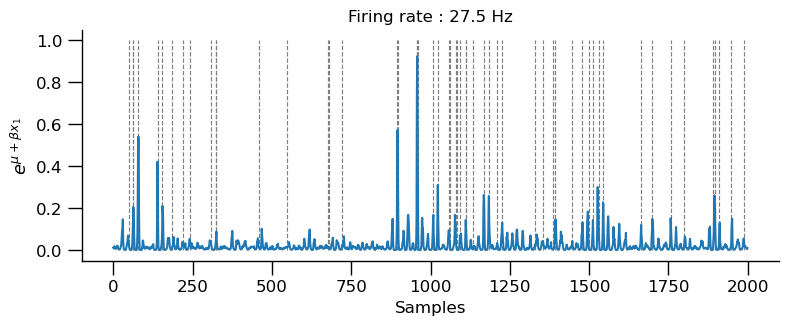

In [112]:
X, y, N, Fs, Delta, alpha, F, omega, R, sigma, mu, beta = get_params(N=2000, random = False, print_params=True, plot=True)

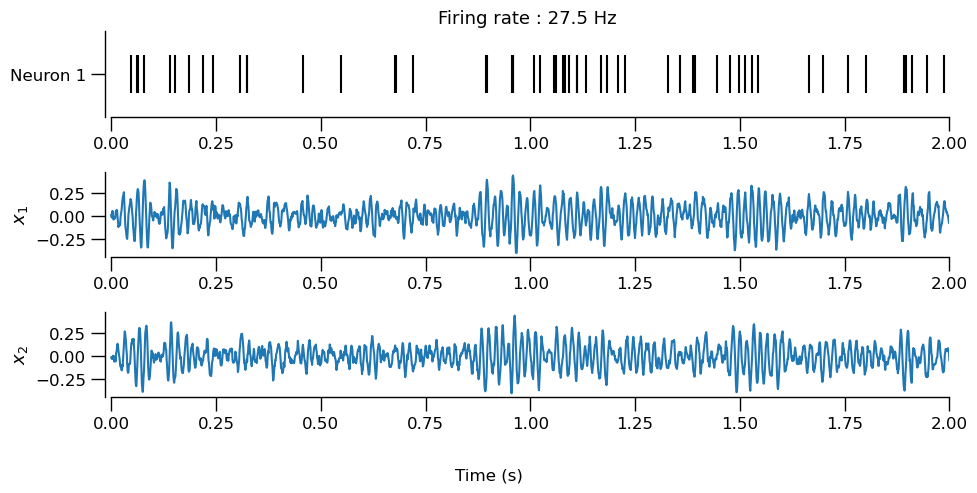

In [113]:
fig, (ax, ax2, ax3) = plt.subplots(3,1, figsize=(10, 5))

time = np.linspace(0, N/Fs, N)
ax.eventplot(np.where(y)[0]/Fs, colors='k', lineoffsets=1, linelengths=1)
# ax.set_xticks(np.linspace(0,N,9), np.linspace(0,N/Fs,9))
# ax.plot(np.where(y)[0], [1]*np.sum(y).astype(int), 'r*')
ax.set_xlim([-15/Fs, N/Fs])
ax.spines['bottom'].set_bounds(0, N/Fs)
ax.set_yticks([1], ['Neuron 1'])
ax.set_title(f'Firing rate : {np.mean(y)*Fs} Hz', fontsize=13)

ax2.plot(time, X[0])
ax2.set_ylabel('$x_{1}$', rotation='vertical')
ax2.set_xlim([-15/Fs, N/Fs])
ax2.spines['bottom'].set_bounds(0, N/Fs)

ax3.plot(time, X[1])
ax3.set_xlim([-15/Fs, N/Fs])
ax3.spines['bottom'].set_bounds(0, N/Fs)
ax3.set_ylabel('$x_{2}$', rotation='vertical')
fig.supxlabel('Time (s)', fontsize=12)
fig.tight_layout()
plt.show()

In [114]:
mu, beta, sigma, alpha, F, Delta

(-4.5, 10, 0.001, 0.973, 60, 0.001)

In [115]:
params, E_steps, [mu_est, alpha_est, F_est, omega_est, sigma_est], error_log = run_EM(y, x0, 
                                                                           mu, beta, sigma, alpha, F, Delta, 
                                                                           iters = 10, method='trust-krylov')
    


1 2 3 4 5 6 7 8 9 Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.
10 Estimation of $x_{m, k}$  failed to converge : A bad approximation caused failure to predict improvement.


In [118]:
np.corrcoef(E_steps['x_b'][0][0], X[0])

array([[1.        , 0.59677328],
       [0.59677328, 1.        ]])

In [119]:
error_log

,n_iter,x0,mu_h,alpha_h,omega_h,sigma_h,msg
0,9,"[0.009636000139791845, -0.014291944870819591]",-91.569735,0.999864,0.0,0.013455,"Estimation of $x_{m, k}$ failed to converge :..."
1,10,"[0.009636000139791845, -0.014291944870819591]",-91.569735,0.999864,0.0,0.013455,"Estimation of $x_{m, k}$ failed to converge :..."


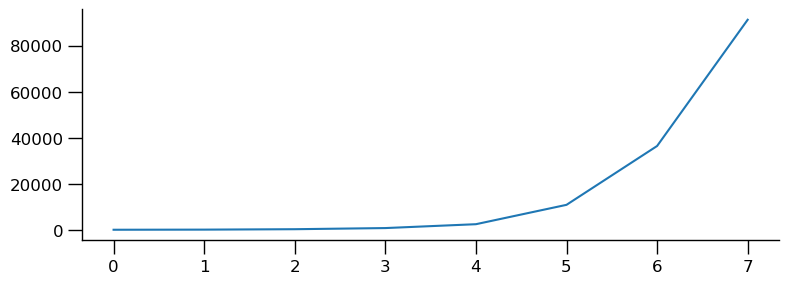

In [120]:
plt.plot(np.array(E_steps['A'])[:, 0,0])

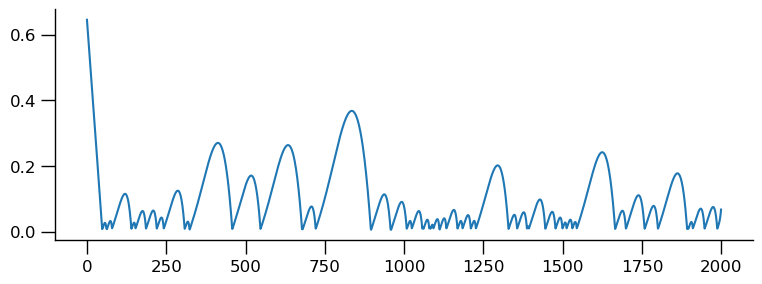

In [121]:
plt.plot(np.array(E_steps['P_b'][7])[0,0, :])

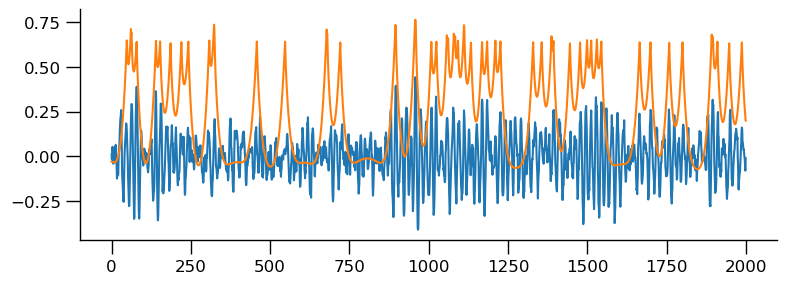

In [122]:

plt.plot(X[0])
plt.plot(np.array(E_steps['x_b'][2])[0])


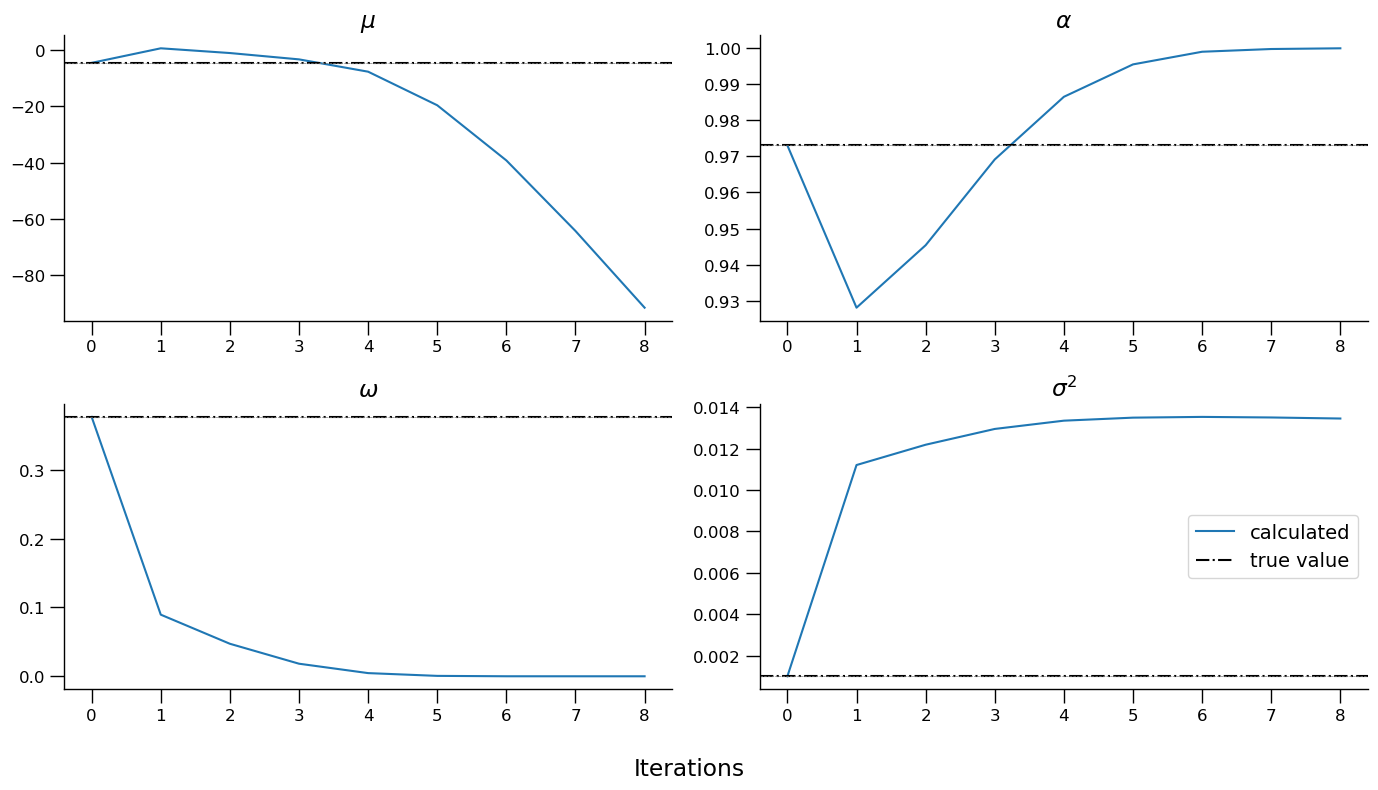

In [123]:
fig,axs = plt.subplots(2,2, figsize=(14,8))
for cols, ax, true_param, ix in zip(params.columns, axs.ravel(), params.loc[0, :], np.arange(4)):
    ax.plot(params.loc[:, cols])
    ax.axhline(true_param, c='k', ls='-.')
    ax.axhline(params.loc[0, cols], c='grey', ls='--', lw=0.5)
    ax.set_title(cols)
ax.legend(['calculated', 'true value'])
fig.supxlabel('Iterations')
fig.tight_layout()
plt.show()


In [327]:
mu

-4.5

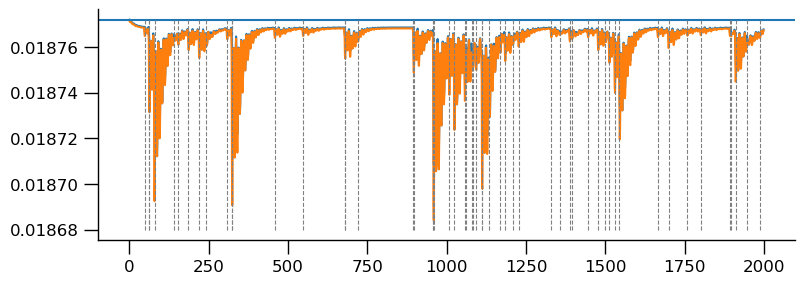

In [322]:
plt.plot(P_pred[0,0, 1:])
plt.plot(P_meas[0,0, 1:])
plt.axhline(sigma / (1 - alpha**2))
plt.vlines(np.where(y)[0], ymax = sigma / (1 - alpha**2), ymin = 0.01868, ls='--', color='grey', lw=0.8)

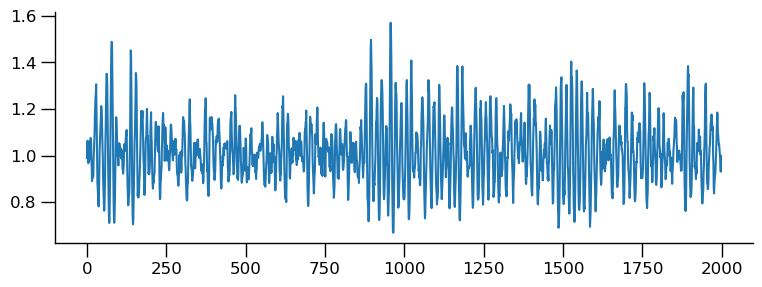

## Indiv steps

In [130]:
y.shape, X.shape, beta, Delta, N

((2000,), (2, 2000), 10, 0.001, 2000)

In [157]:
A, B, C = E_step(X, P_try, E_steps['BG'][0], N)

In [158]:
M_step(A, B, C, X, P_try, y, N, beta, Delta)

(1.5112721064803525,
 0.9128643974090632,
 0.13665913690204906,
 0.009007964574734963)

In [146]:
P_try = sigma/(1- alpha**2) * np.repeat(np.eye(2).reshape(2,2,1), N, axis=2)

In [151]:
E_steps['BG'][0].shape

(2, 2, 2000)

In [312]:
mu, alpha, omega, sigma

(-4.5, 0.973, 0.37699111843077515, 0.001)

In [273]:
ee = np.log(np.exp(beta*X[0, 1:N] + np.power(beta,2)*P_smooth[0,0,1:N]/2).sum())

In [274]:
np.log(np.sum(y)) - ee - np.log(Delta)

0.6634079002769147

In [249]:
np.exp(beta*x_b[0, 1:K-1] + np.power(beta,2)*P_b[0,0,1:K-1]/2).sum()

289

In [241]:
np.log(np.exp(beta*x_smooth[0, 1:N] + np.power(beta,2)*P_smooth[0,0,1:N]/2).sum())

13.49223610774112

In [272]:
uu = np.log(np.sum(y)) - np.log((np.exp(beta*x_smooth[0, 1:N] + np.power(beta,2)*P_smooth[0,0,1:N]/2)*Delta).sum())

In [271]:
mu, uu

(-4.672269836786217, 4.5999405692392115)

In [267]:
y.sum()*Fs

72000.0

# Gaussian Likelihood Trial

In [102]:
def kalman_filter(data, F, H, Q, R, likelihood_fun):

    '''
    Parameters
    ------------
        data: a Ny x T matrix containing data (y(1), ... , y(T)).
        F: Nz x Nz matrix a time-invariant transition matrix in the transition equation.
        H: Ny x Nz matrix a time-invariant measurement matrix in the measurement equation.
        Q:  (Nz) x (Nz) matrix time-invariant variance matrix for the error in the transition equation.
        R:  (Ny) x (Nz) matrix time-invariant variance matrix for the error in the measurement equation.
        likilihood_fun : likelihood function for the posterior estimation of x_{k|k}, i.e. log p(xk|H(k)) expression
        in (8) as a function of $(x_k, x_{k|k-1}, P_{k|k-1}, y_k, \\mu_c)$.
         
    Returns
    --------
    
    '''

pass

In [ ]:
def djkalman(F, Q, mu0, S0, G, R, y, R_weights=None, skip_interp=True):
    """
    This is the [De Jong 1989] Kalman filter and fixed-interval smoother.
    Multivariate observation data y is supported. This implementation runs
    the kalman filtering and smoothing on CPU. This function has been heavily
    optimized for matrix computations in exchange for more intense memory use
    and arcane syntax. Note the filtered estimates are skipped since not used
    during recursion. If you need filtered estimate, refer to the equations
    derived in the MATLAB human-readable version (under <archive>) and add to
    the for loop.

    Since De Jong Kalman filtering and smoothing are not defined at t=0, we
    repeat the estimates at t=1 to extend to t=0. This is useful to allow
    updating initial state and covariance estimates in the M step.

    Reference:
        De Jong, P. (1989). Smoothing and interpolation with the
        state-space model. Journal of the American Statistical
        Association, 84(408), 1085-1088.

    Inputs
    :param F: transition matrix
    :param Q: state noise covariance matrix
    :param mu0: initial state mean vector
    :param S0: initial state covariance matrix
    :param G: observation matrix
    :param R: observation noise covariance matrix
    :param y: observed data (can be multivariate)
    :param R_weights: time-varying weights on the observation
            noise covariance (default: uniform unit weights)
    :param skip_interp: whether to skip calculating interpolated density
    :return: x_t_n, P_t_n, P_t_tmin1_n, logL, x_t_t, P_t_t, K_t, x_t_tmin1, P_t_tmin1, fy_t_interp
    """
    # Vector dimensions
    q, T = y.shape
    p = mu0.shape[0]
    approach_y = 'svd' if q >= 5 else 'gaussian'

    # Expand observation noise R to all time points
    R = apply_R_weights(R, q, T, R_weights=R_weights)

    # Kalman filtering (forward pass)
    x_t_tmin1 = np.zeros((p, T+2))  # (index 1 corresponds to t=0, etc.)
    P_t_tmin1 = np.zeros((p, p, T+2))
    K_t = np.zeros((p, q, T+1))  # note that this is different from the classical Kalman gain by pre-multiplying with F
    e_t = np.zeros((q, T+1))
    invD_t = np.zeros((q, q, T+1))
    L_t = np.zeros((p, p, T+1))
    logL = np.zeros(T)  # (index 1 corresponds to t=1)
    qlog2pi = q * np.log(2 * np.pi)

    # Initialize
    x_t_t = mu0  # x_0_0, initialized only to keep return outputs consistent
    P_t_t = S0  # P_0_0, initialized only to keep return outputs consistent
    x_t_tmin1[:, 1] = F @ np.squeeze(x_t_t, axis=1)  # x_1_0 (W_0*beta in De Jong 1989)
    P_t_tmin1[:, :, 1] = F @ P_t_t @ F.T + Q  # P_1_0 (V_0 in De Jong 1989)

    # Recursion of forward pass
    for ii in range(1, T+1):  # t=1 -> t=T
        # Intermediate vectors
        e_t[:, ii] = y[:, ii-1] - G @ x_t_tmin1[:, ii]  # same as dy in classical kalman
        D_t = G @ P_t_tmin1[:, :, ii] @ G.T + R[:, :, ii-1]  # same as Sigma in classical kalman
        invD_t[:, :, ii] = inverse(D_t, approach=approach_y)
        FP = F @ P_t_tmin1[:, :, ii]
        K_t[:, :, ii] = FP @ G.T @ invD_t[:, :, ii]
        L_t[:, :, ii] = F - K_t[:, :, ii] @ G

        # One-step prediction for the next time point
        x_t_tmin1[:, ii+1] = F @ x_t_tmin1[:, ii] + K_t[:, :, ii] @ e_t[:, ii]
        P_t_tmin1[:, :, ii+1] = FP @ L_t[:, :, ii].T + Q

        # Innovation form of the log likelihood
        logL[ii-1] = -(qlog2pi + logdet(D_t) + e_t[:, ii].T @ invD_t[:, :, ii] @ e_t[:, ii]) / 2

    # remove the extra t=T+1 time point created
    x_t_tmin1 = x_t_tmin1[:, :-1]
    P_t_tmin1 = P_t_tmin1[:, :, :-1]

    # Kalman smoothing (backward pass)
    r_t = np.zeros((p, T+1))  # (index 1 corresponds to t=0, etc.)
    R_t = np.zeros((p, p, T+1))
    x_t_n = np.zeros((p, T+1))
    P_t_n = np.zeros((p, p, T+1))
    P_t_tmin1_n = np.zeros((p, p, T+1))  # cross-covariance between t and t-1
    Ip = np.eye(p)

    # Recursion of backward pass - fixed-interval smoothing
    for ii in range(T, 0, -1):  # t=T -> t=1
        # Intermediate vectors
        GD = G.T @ invD_t[:, :, ii]
        r_t[:, ii-1] = GD @ e_t[:, ii] + L_t[:, :, ii].T @ r_t[:, ii]
        R_t[:, :, ii-1] = GD @ G + L_t[:, :, ii].T @ R_t[:, :, ii] @ L_t[:, :, ii]

        # Smoothed estimates
        x_t_n[:, ii] = x_t_tmin1[:, ii] + P_t_tmin1[:, :, ii] @ r_t[:, ii-1]
        RP = R_t[:, :, ii-1] @ P_t_tmin1[:, :, ii]
        P_t_n[:, :, ii] = P_t_tmin1[:, :, ii] @ (Ip - RP)
        # Cov(t,t-1) is derived using Theorem 1 and Lemma 1, m = t, s = t+1
        P_t_tmin1_n[:, :, ii] = (Ip - RP.T) @ L_t[:, :, ii-1] @ P_t_tmin1[:, :, ii-1].T

    # Set the cross-covariance estimate at t=1. Cov(t=1,t=0) can be computed exactly using J_0.
    # But we use P_t=1_n instead to avoid inverting conditional state noise covariance.
    P_t_tmin1_n[:, :, 1] = P_t_n[:, :, 1]

    # Repeat t=1 to extend the smoothed estimates to t=0
    x_t_n[:, 0] = x_t_n[:, 1]
    P_t_n[:, :, 0] = P_t_n[:, :, 1]

    # Interpolated conditional density of y_t
    if skip_interp:
        fy_t_interp = float('nan')
    else:
        # fy_t_interp = normpdf(y_t | y_1,...,y_t-1,y_t+1,y_T)
        fy_t_interp = np.zeros(T)  # (index 1 corresponds to t=1, etc.)
        for ii in range(T):  # t=1 -> t=T
            n_t = invD_t[:, :, ii+1] @ e_t[:, ii+1] - K_t[:, :, ii+1].T @ r_t[:, ii+1]
            N_t = invD_t[:, :, ii+1] + K_t[:, :, ii+1].T @ R_t[:, :, ii+1] @ K_t[:, :, ii+1]
            # See De Jong 1989 Section 5, note that -logdet(N_t) is NOT a typo
            if np.linalg.cond(N_t) < (1 / np.finfo(float).eps):
                invN_t = inverse(N_t, approach=approach_y)
            else:
                invN_t = np.ones(N_t.shape, dtype=np.float64) * float('inf')
            fy_t_interp[ii] = np.exp(-(qlog2pi - logdet(N_t) + n_t.T @ invN_t @ n_t) / 2)

    return x_t_n, P_t_n, P_t_tmin1_n, logL, x_t_t, P_t_t, K_t, x_t_tmin1, P_t_tmin1, fy_t_interp